In this section, I'll be delving into time series forecasting using deep learning models, specifically Recurrent Neural Networks (RNN), Gated Recurrent Units (GRU), and Long Short-Term Memory (LSTM). I'll compare the performance of these deep learning models against traditional ARMA/ARIMA/SARIMA models to gauge their effectiveness in forecasting time series data.


In [251]:
# import packages

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime

In [252]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from keras.layers import Dense, SimpleRNN, LSTM, GRU

In [253]:
# Load Canada freight data
canada = pd.read_csv("data/clean_data/24monthly_canada_freight.csv", usecols=["Date", "Value"])
canada['Date'] = pd.to_datetime(canada['Date'])

# Load employment data
employment = pd.read_csv("data/clean_data/32monthly_employment.csv", usecols=["Date", "Transportation Employment - Air Transportation"])
employment['Date'] = pd.to_datetime(employment['Date'])

# Load TSI data
tsi = pd.read_csv("data/clean_data/35monthly_TSI.csv")
tsi['Date'] = pd.to_datetime(tsi['Date'])

# Load air carrier data
air = pd.read_csv("data/clean_data/33revenue.csv")
air = air[air['Mode'] == "Air carrier, domestic"]
air = air[['Year', 'Value']]
air = air.sort_values(by='Year')
air['Year'] = pd.to_datetime(air['Year'], format="%Y")

# Load UPS stock data
ups = pd.read_csv("data/clean_data/ups.csv")
ups['date'] = pd.to_datetime(ups['date'])


# Deep Learning for Time Series

## Data Visualization

::: panel-tabset

### U.S.-Canada Freight Value


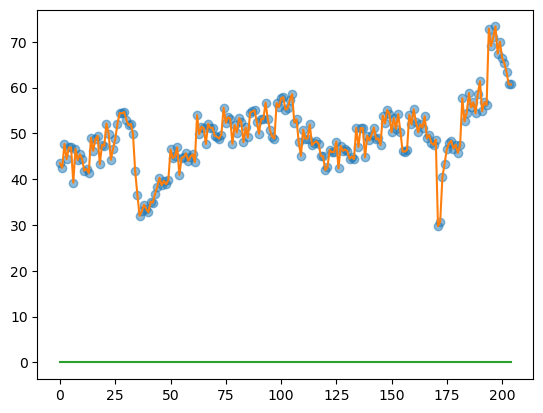

In [254]:
t_canada = np.array([*range(0,canada.shape[0])])
x_canada = np.array(canada['Value']).reshape(t_canada.shape[0],1)
feature_columns_canada = [0]
target_columns_canada = [0]

fig, ax = plt.subplots()
for i in range(0,x_canada.shape[1]):
    ax.plot(t_canada, x_canada[:,i],'o',alpha = 0.5)
    ax.plot(t_canada, x_canada[:,i],"-")
ax.plot(t_canada, 0*x_canada[:,0],"-") # add baseline for reference 
plt.show()

### U.S. Air Transportation Employment

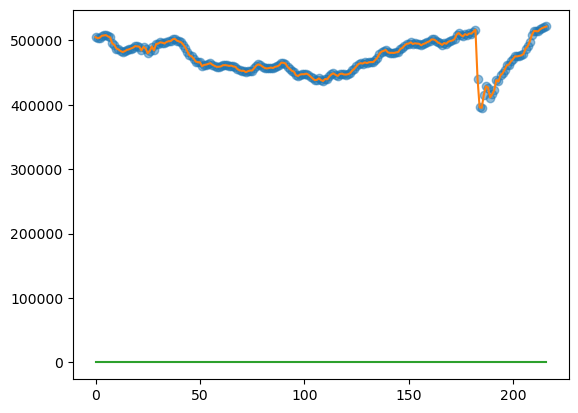

In [255]:
t_employment = np.array([*range(0,employment.shape[0])])
x_employment = np.array(employment['Transportation Employment - Air Transportation']).reshape(t_employment.shape[0],1)
feature_columns_employment = [0]
target_columns_employment = [0]

fig, ax = plt.subplots()
for i in range(0,x_employment.shape[1]):
    ax.plot(t_employment, x_employment[:,i],'o',alpha = 0.5)
    ax.plot(t_employment, x_employment[:,i],"-")
ax.plot(t_employment, 0*x_employment[:,0],"-") # add baseline for reference 
plt.show()

### U.S. Freight Transportation Services Index

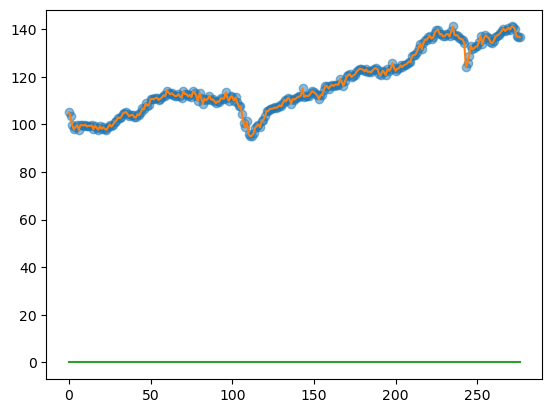

In [256]:
t_tsi = np.array([*range(0,tsi.shape[0])])
x_tsi = np.array(tsi['Transportation Services Index - Freight']).reshape(t_tsi.shape[0],1)
feature_columns_tsi = [0]
target_columns_tsi = [0]

fig, ax = plt.subplots()
for i in range(0,x_tsi.shape[1]):
    ax.plot(t_tsi, x_tsi[:,i],'o',alpha = 0.5)
    ax.plot(t_tsi, x_tsi[:,i],"-")
ax.plot(t_tsi, 0*x_tsi[:,0],"-") # add baseline for reference 
plt.show()

### U.S. Domestic Air Carrier Average Freight Revenue

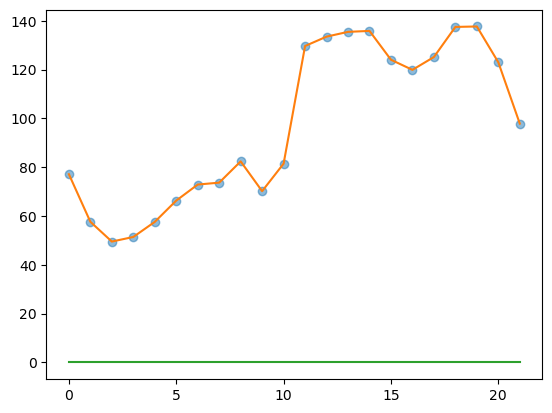

In [257]:
t_air = np.array([*range(0,air.shape[0])])
x_air = np.array(air['Value']).reshape(t_air.shape[0],1)
feature_columns_air = [0]
target_columns_air = [0]

fig, ax = plt.subplots()
for i in range(0,x_air.shape[1]):
    ax.plot(t_air, x_air[:,i],'o',alpha = 0.5)
    ax.plot(t_air, x_air[:,i],"-")
ax.plot(t_air, 0*x_air[:,0],"-") # add baseline for reference 
plt.show()

### UPS Stock Price


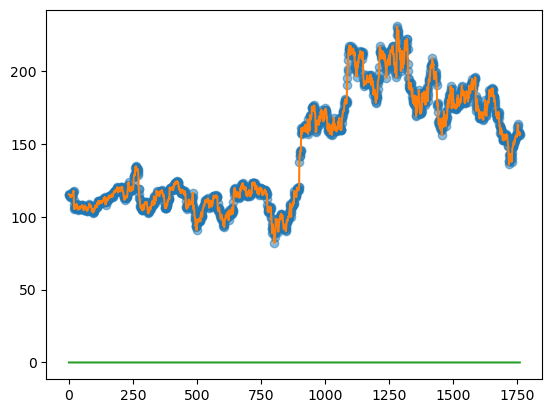

In [258]:
t_ups = np.array([*range(0,ups.shape[0])])
x_ups = np.array(ups['UPS.Adjusted']).reshape(t_ups.shape[0],1)
feature_columns_ups = [0]
target_columns_ups = [0]

fig, ax = plt.subplots()
for i in range(0,x_ups.shape[1]):
    ax.plot(t_ups, x_ups[:,i],'o',alpha = 0.5)
    ax.plot(t_ups, x_ups[:,i],"-")
ax.plot(t_ups, 0*x_ups[:,0],"-") # add baseline for reference 
plt.show()

:::


## Split Data & Normalize

::: panel-tabset

### U.S.-Canada Freight Value

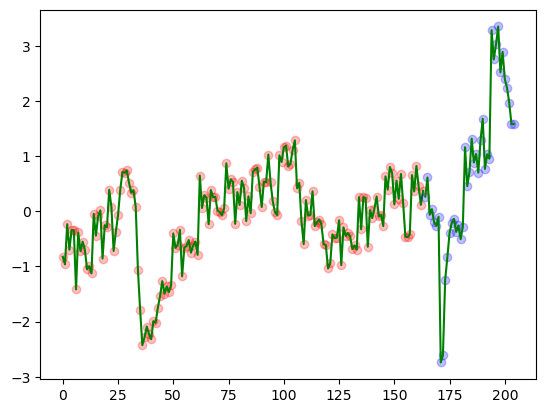

In [259]:
# normalize
x_canada=(x_canada-np.mean(x_canada,axis=0))/np.std(x_canada,axis=0)

# split data
split_fr = 0.8
cut=int(split_fr*x_canada.shape[0])
tt_canada=t_canada[0:cut]; xt_canada=x_canada[0:cut]
tv_canada=t_canada[cut:]; xv_canada=x_canada[cut:]

# visualize the normalized data
fig, ax = plt.subplots()
for i in range(0,x_canada.shape[1]):
    ax.plot(tt_canada, xt_canada[:,i],'ro',alpha=0.25)
    ax.plot(tt_canada, xt_canada[:,i],"g-")
for i in range(0,x_canada.shape[1]):
    ax.plot(tv_canada, xv_canada[:,i],'bo',alpha=0.25)
    ax.plot(tv_canada, xv_canada[:,i],"g-")
plt.show()


### U.S. Air Transportation Employment


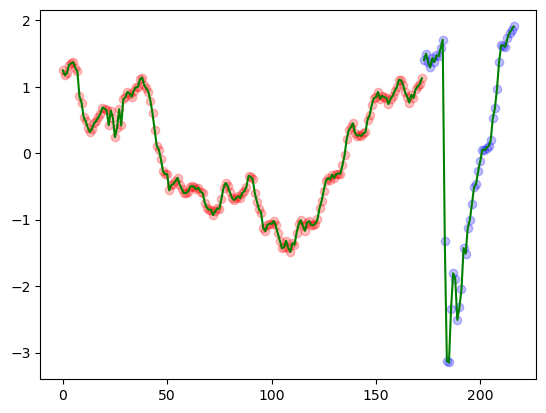

In [260]:
# normalize
x_employment=(x_employment-np.mean(x_employment,axis=0))/np.std(x_employment,axis=0)

# split data
split_fr = 0.8
cut=int(split_fr*x_employment.shape[0])
tt_employment=t_employment[0:cut]; xt_employment=x_employment[0:cut]
tv_employment=t_employment[cut:]; xv_employment=x_employment[cut:]

# visualize the normalized data
fig, ax = plt.subplots()
for i in range(0,x_employment.shape[1]):
    ax.plot(tt_employment, xt_employment[:,i],'ro',alpha=0.25)
    ax.plot(tt_employment, xt_employment[:,i],"g-")
for i in range(0,x_employment.shape[1]):
    ax.plot(tv_employment, xv_employment[:,i],'bo',alpha=0.25)
    ax.plot(tv_employment, xv_employment[:,i],"g-")
plt.show()

### U.S. Freight Transportation Services Index

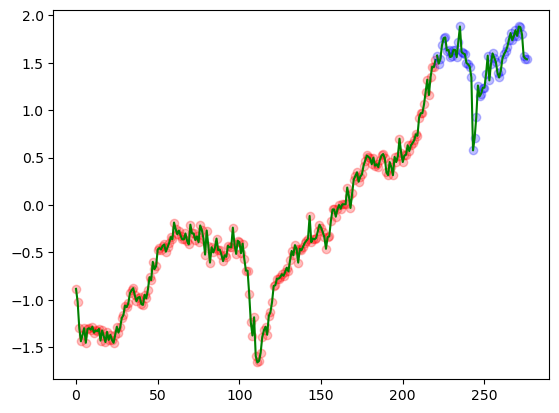

In [261]:
# normalize
x_tsi=(x_tsi-np.mean(x_tsi,axis=0))/np.std(x_tsi,axis=0)

# split data
split_fr = 0.8
cut=int(split_fr*x_tsi.shape[0])
tt_tsi=t_tsi[0:cut]; xt_tsi=x_tsi[0:cut]
tv_tsi=t_tsi[cut:]; xv_tsi=x_tsi[cut:]

# visualize the normalized data
fig, ax = plt.subplots()
for i in range(0,x_tsi.shape[1]):
    ax.plot(tt_tsi, xt_tsi[:,i],'ro',alpha=0.25)
    ax.plot(tt_tsi, xt_tsi[:,i],"g-")
for i in range(0,x_tsi.shape[1]):
    ax.plot(tv_tsi, xv_tsi[:,i],'bo',alpha=0.25)
    ax.plot(tv_tsi, xv_tsi[:,i],"g-")
plt.show()

### U.S. Domestic Air Carrier Average Freight Revenue

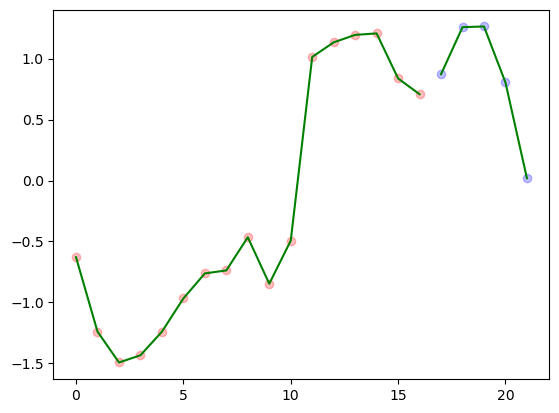

In [262]:
# normalize
x_air=(x_air-np.mean(x_air,axis=0))/np.std(x_air,axis=0)

# split data
split_fr = 0.8
cut=int(split_fr*x_air.shape[0])
tt_air=t_air[0:cut]; xt_air=x_air[0:cut]
tv_air=t_air[cut:]; xv_air=x_air[cut:]

# visualize the normalized data
fig, ax = plt.subplots()
for i in range(0,x_air.shape[1]):
    ax.plot(tt_air, xt_air[:,i],'ro',alpha=0.25)
    ax.plot(tt_air, xt_air[:,i],"g-")
for i in range(0,x_air.shape[1]):
    ax.plot(tv_air, xv_air[:,i],'bo',alpha=0.25)
    ax.plot(tv_air, xv_air[:,i],"g-")
plt.show()

### UPS Stock Price


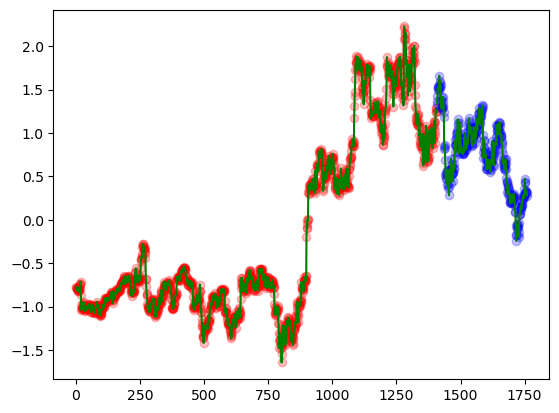

In [263]:
# normalize
x_ups=(x_ups-np.mean(x_ups,axis=0))/np.std(x_ups,axis=0)

# split data
split_fr = 0.8
cut=int(split_fr*x_ups.shape[0])
tt_ups=t_ups[0:cut]; xt_ups=x_ups[0:cut]
tv_ups=t_ups[cut:]; xv_ups=x_ups[cut:]

# visualize the normalized data
fig, ax = plt.subplots()
for i in range(0,x_ups.shape[1]):
    ax.plot(tt_ups, xt_ups[:,i],'ro',alpha=0.25)
    ax.plot(tt_ups, xt_ups[:,i],"g-")
for i in range(0,x_ups.shape[1]):
    ax.plot(tv_ups, xv_ups[:,i],'bo',alpha=0.25)
    ax.plot(tv_ups, xv_ups[:,i],"g-")
plt.show()

:::


## Mini-Batching

In [264]:

def from_arrays(x, lookback=3, delay=1, step=1, feature_columns=[0], target_columns=[0], unique=False, verbose=False):
    # initialize 
    i_start = 0
    count = 0
    x_out = []
    y_out = []

    # sequentially build mini-batch samples
    while i_start + lookback + delay < x.shape[0]:
        i_stop = i_start + lookback
        i_pred = i_stop + delay

        # report if desired 
        if verbose and count < 2: 
            print("indice range:", i_start, i_stop, "-->", i_pred)

        # define arrays: 
        indices_to_keep = []
        j = i_stop
        while j >= i_start:
            indices_to_keep.append(j)
            j -= step

        # create mini-batch sample
        xtmp = x[indices_to_keep, :]    # isolate relevant indices
        xtmp = xtmp[:, feature_columns] # isolate desired features
        ytmp = x[i_pred, target_columns]
        x_out.append(xtmp)
        y_out.append(ytmp)

        # report if desired 
        if verbose and count < 2: 
            print(xtmp, "-->", ytmp)
            print("shape:", xtmp.shape, "-->", ytmp.shape)

        # Plot for debugging    
        if verbose and count < 2:
            fig, ax = plt.subplots()
            ax.plot(x, 'b-')
            ax.plot(x, 'bx')
            ax.plot(indices_to_keep, xtmp, 'go')
            ax.plot(i_pred * np.ones(len(target_columns)), ytmp, 'ro')
            plt.show()

        # Update start point 
        if unique:
            i_start += lookback
        else:
            i_start += 1
        count += 1

    return np.array(x_out), np.array(y_out)

::: panel-tabset

### U.S.-Canada Freight Value

indice range: 0 5 --> 6
[[-0.34147078]
 [-0.3412051 ]
 [-0.69621512]
 [-0.23380024]
 [-0.96207443]
 [-0.82435514]] --> [-1.41602869]
shape: (6, 1) --> (1,)


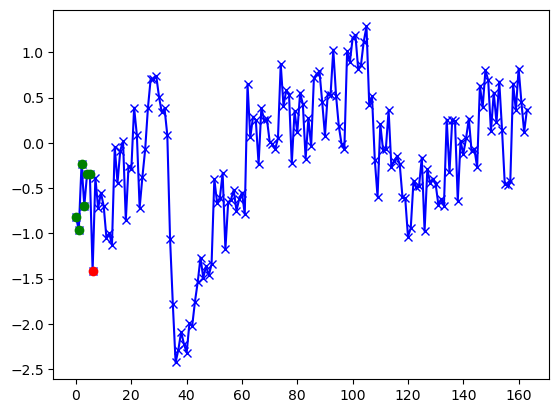

indice range: 1 6 --> 7
[[-1.41602869]
 [-0.34147078]
 [-0.3412051 ]
 [-0.69621512]
 [-0.23380024]
 [-0.96207443]] --> [-0.38448617]
shape: (6, 1) --> (1,)


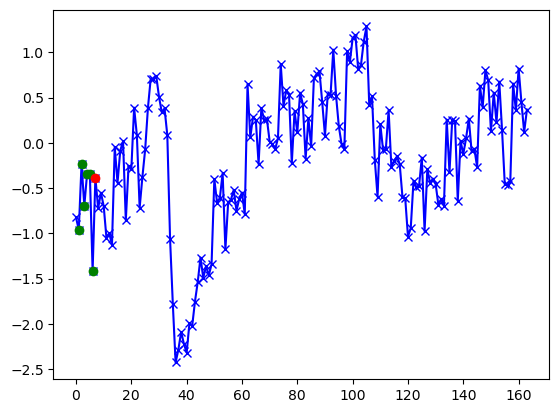

indice range: 0 5 --> 6
[[-0.26320923]
 [-0.20273651]
 [ 0.03881935]
 [-0.06297483]
 [ 0.61220025]
 [ 0.26658203]] --> [-0.10089611]
shape: (6, 1) --> (1,)


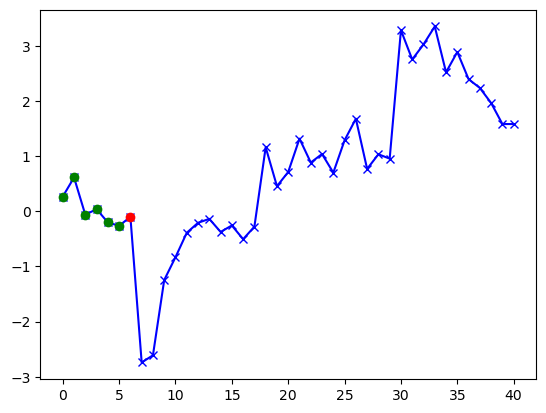

indice range: 1 6 --> 7
[[-0.10089611]
 [-0.26320923]
 [-0.20273651]
 [ 0.03881935]
 [-0.06297483]
 [ 0.61220025]] --> [-2.73966548]
shape: (6, 1) --> (1,)


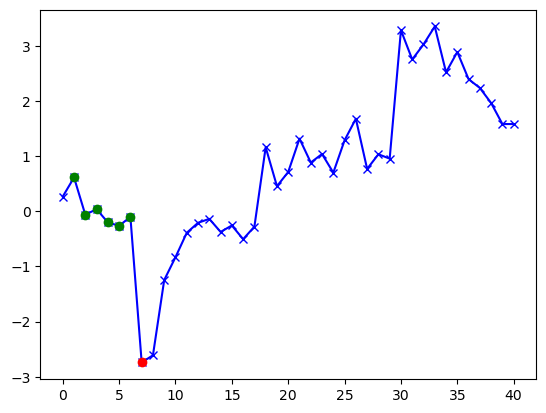

Training: (158, 6, 1) (158, 1)
Validation: (35, 6, 1) (35, 1)


In [265]:
Xt_canada, Yt_canada = from_arrays(xt_canada, lookback=5, delay=1, step=1, 
                                   feature_columns=feature_columns_canada, 
                                   target_columns=target_columns_canada, unique=False,verbose=True)
Xv_canada, Yv_canada = from_arrays(xv_canada, lookback=5, delay=1, step=1, 
                                   feature_columns=feature_columns_canada, 
                                   target_columns=target_columns_canada, unique=False,verbose=True)

print('Training:', Xt_canada.shape, Yt_canada.shape)
print('Validation:', Xv_canada.shape, Yv_canada.shape)

### U.S. Air Transportation Employment


indice range: 0 5 --> 6
[[1.36990465]
 [1.34989352]
 [1.32988239]
 [1.2058134 ]
 [1.17379559]
 [1.24583565]] --> [1.28585791]
shape: (6, 1) --> (1,)


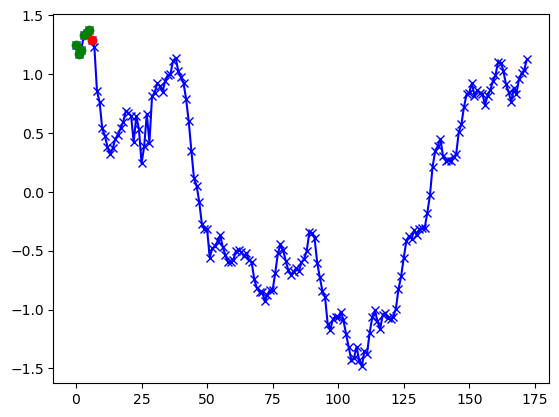

indice range: 1 6 --> 7
[[1.28585791]
 [1.36990465]
 [1.34989352]
 [1.32988239]
 [1.2058134 ]
 [1.17379559]] --> [1.22982675]
shape: (6, 1) --> (1,)


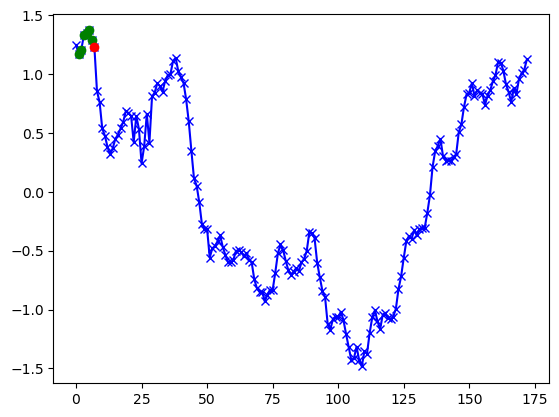

indice range: 0 5 --> 6
[[1.36990465]
 [1.42993803]
 [1.28986013]
 [1.36990465]
 [1.49797586]
 [1.40192245]] --> [1.46996029]
shape: (6, 1) --> (1,)


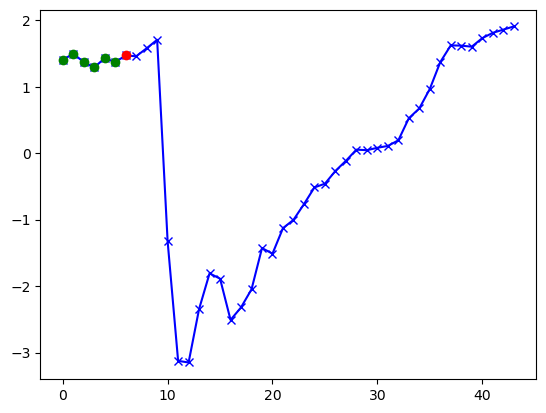

indice range: 1 6 --> 7
[[1.46996029]
 [1.36990465]
 [1.42993803]
 [1.28986013]
 [1.36990465]
 [1.49797586]] --> [1.45795361]
shape: (6, 1) --> (1,)


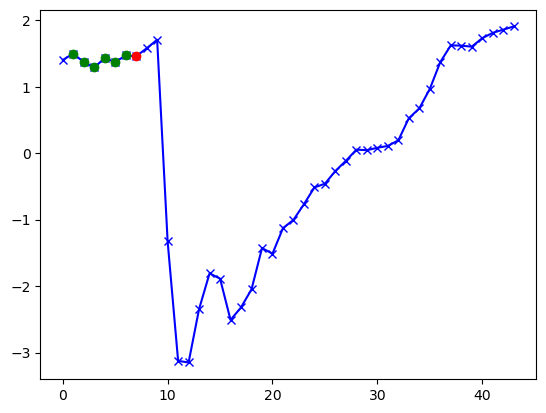

Training: (167, 6, 1) (167, 1)
Validation: (38, 6, 1) (38, 1)


In [266]:
Xt_employment, Yt_employment = from_arrays(xt_employment, lookback=5, delay=1, step=1, 
                                   feature_columns=feature_columns_employment, 
                                   target_columns=target_columns_employment, unique=False,verbose=True)

Xv_employment, Yv_employment = from_arrays(xv_employment, lookback=5, delay=1, step=1, 
                                   feature_columns=feature_columns_employment, 
                                   target_columns=target_columns_employment, unique=False,verbose=True)

print('Training:', Xt_employment.shape, Yt_employment.shape)
print('Validation:', Xv_employment.shape, Yv_employment.shape)

### U.S. Freight Transportation Services Index

indice range: 0 5 --> 6
[[-1.2993489 ]
 [-1.36852726]
 [-1.43770562]
 [-1.2993489 ]
 [-1.02263545]
 [-0.88427873]] --> [-1.45307859]
shape: (6, 1) --> (1,)


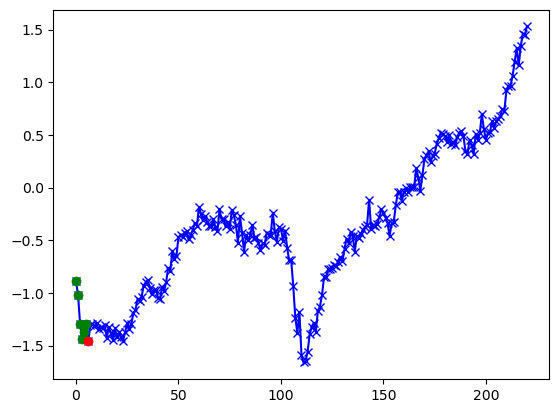

indice range: 1 6 --> 7
[[-1.45307859]
 [-1.2993489 ]
 [-1.36852726]
 [-1.43770562]
 [-1.2993489 ]
 [-1.02263545]] --> [-1.30703538]
shape: (6, 1) --> (1,)


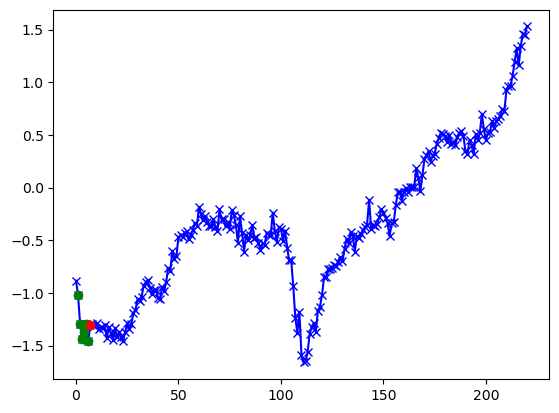

indice range: 0 5 --> 6
[[1.76755849]
 [1.759872  ]
 [1.68300715]
 [1.53696395]
 [1.49084504]
 [1.57539637]] --> [1.62920176]
shape: (6, 1) --> (1,)


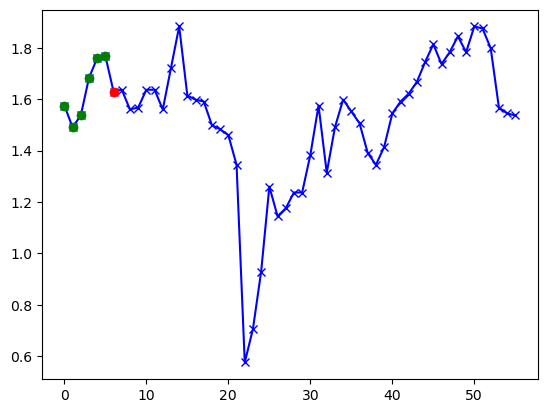

indice range: 1 6 --> 7
[[1.62920176]
 [1.76755849]
 [1.759872  ]
 [1.68300715]
 [1.53696395]
 [1.49084504]] --> [1.63688825]
shape: (6, 1) --> (1,)


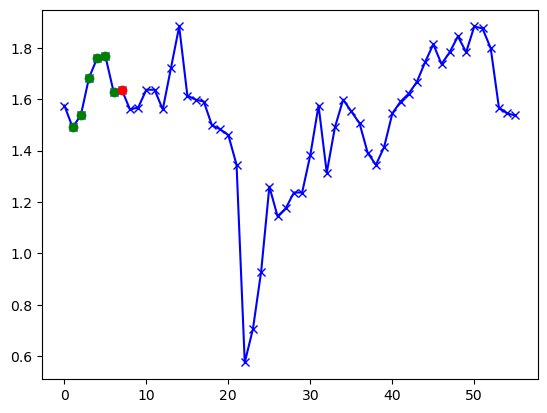

Training: (215, 6, 1) (215, 1)
Validation: (50, 6, 1) (50, 1)


In [267]:
Xt_tsi, Yt_tsi = from_arrays(xt_tsi, lookback=5, delay=1, step=1, 
                                   feature_columns=feature_columns_tsi, 
                                   target_columns=target_columns_tsi, unique=False,verbose=True)

Xv_tsi, Yv_tsi = from_arrays(xv_tsi, lookback=5, delay=1, step=1, 
                                   feature_columns=feature_columns_tsi, 
                                   target_columns=target_columns_tsi, unique=False,verbose=True)

print('Training:', Xt_tsi.shape, Yt_tsi.shape)
print('Validation:', Xv_tsi.shape, Yv_tsi.shape)

### U.S. Domestic Air Carrier Average Freight Revenue

indice range: 0 2 --> 3
[[-1.49360337]
 [-1.24000539]
 [-0.62986392]] --> [-1.43455834]
shape: (3, 1) --> (1,)


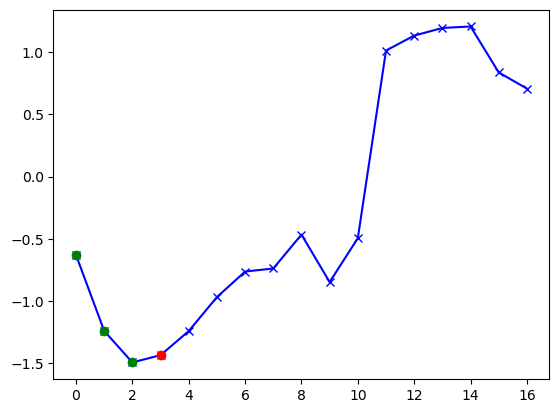

indice range: 1 3 --> 4
[[-1.43455834]
 [-1.49360337]
 [-1.24000539]] --> [-1.24101311]
shape: (3, 1) --> (1,)


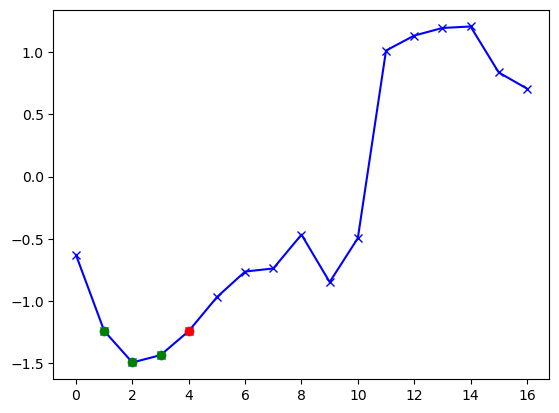

indice range: 0 2 --> 3
[[1.26425541]
 [1.258548  ]
 [0.87248119]] --> [0.80456066]
shape: (3, 1) --> (1,)


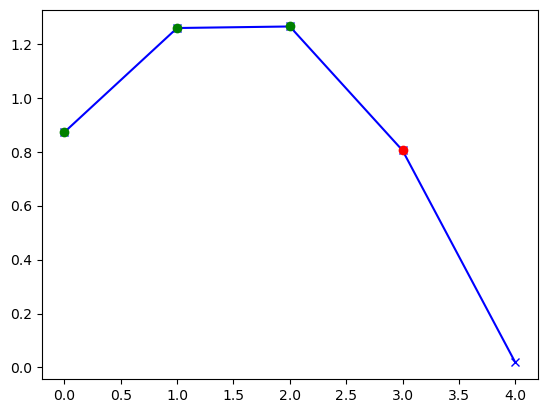

indice range: 1 3 --> 4
[[0.80456066]
 [1.26425541]
 [1.258548  ]] --> [0.0184795]
shape: (3, 1) --> (1,)


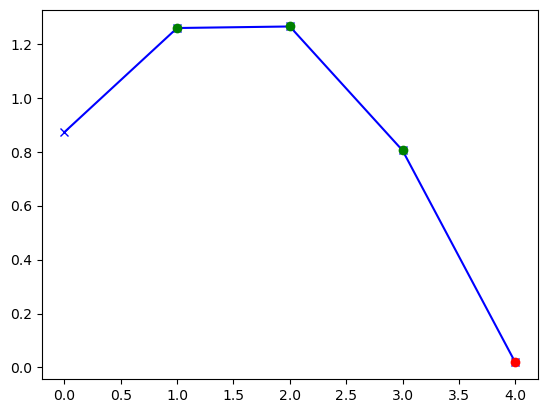

Training: (14, 3, 1) (14, 1)
Validation: (2, 3, 1) (2, 1)


In [268]:
Xt_air, Yt_air = from_arrays(xt_air, lookback=2, delay=1, step=1, 
                                   feature_columns=feature_columns_air, 
                                   target_columns=target_columns_air, unique=False,verbose=True)

Xv_air, Yv_air = from_arrays(xv_air, lookback=2, delay=1, step=1, 
                                   feature_columns=feature_columns_air, 
                                   target_columns=target_columns_air, unique=False,verbose=True)

print('Training:', Xt_air.shape, Yt_air.shape)
print('Validation:', Xv_air.shape, Yv_air.shape)

### UPS Stock Price


indice range: 0 25 --> 26
[[-1.02890762]
 [-1.01403795]
 [-1.00777689]
 [-1.03177723]
 [-1.04247286]
 [-0.97725496]
 [-0.87238468]
 [-0.71325287]
 [-0.73699227]
 [-0.73777486]
 [-0.7570793 ]
 [-0.79960149]
 [-0.78942751]
 [-0.80377533]
 [-0.78994917]
 [-0.80560142]
 [-0.8233407 ]
 [-0.81003639]
 [-0.80977547]
 [-0.82464514]
 [-0.79881891]
 [-0.78916659]
 [-0.78916659]
 [-0.78916659]
 [-0.78134036]
 [-0.77560135]] --> [-1.01977696]
shape: (26, 1) --> (1,)


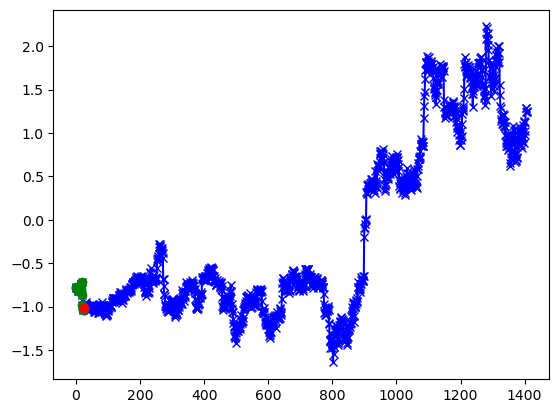

indice range: 1 26 --> 27
[[-1.01977696]
 [-1.02890762]
 [-1.01403795]
 [-1.00777689]
 [-1.03177723]
 [-1.04247286]
 [-0.97725496]
 [-0.87238468]
 [-0.71325287]
 [-0.73699227]
 [-0.73777486]
 [-0.7570793 ]
 [-0.79960149]
 [-0.78942751]
 [-0.80377533]
 [-0.78994917]
 [-0.80560142]
 [-0.8233407 ]
 [-0.81003639]
 [-0.80977547]
 [-0.82464514]
 [-0.79881891]
 [-0.78916659]
 [-0.78916659]
 [-0.78916659]
 [-0.78134036]] --> [-1.01090742]
shape: (26, 1) --> (1,)


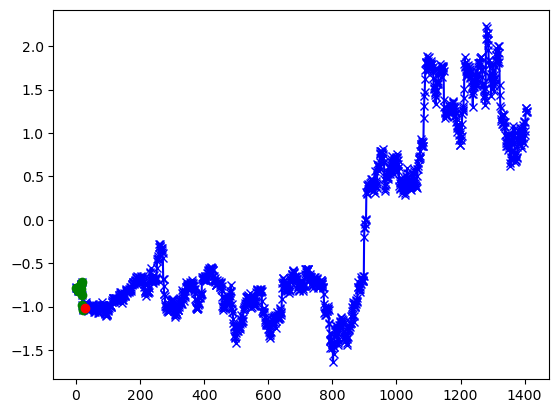

indice range: 0 25 --> 26
[[1.32806716]
 [1.41650261]
 [1.36485015]
 [1.30406703]
 [1.29519709]
 [1.29232749]
 [1.41311115]
 [1.28163206]
 [1.30354517]
 [1.36745863]
 [1.38337181]
 [1.5555472 ]
 [1.5242423 ]
 [1.5299815 ]
 [1.60015602]
 [1.57172111]
 [1.66067841]
 [1.54276435]
 [1.49319891]
 [1.5393729 ]
 [1.52841634]
 [1.49450295]
 [1.51589461]
 [1.42224182]
 [1.33615412]
 [1.37241525]] --> [1.24145761]
shape: (26, 1) --> (1,)


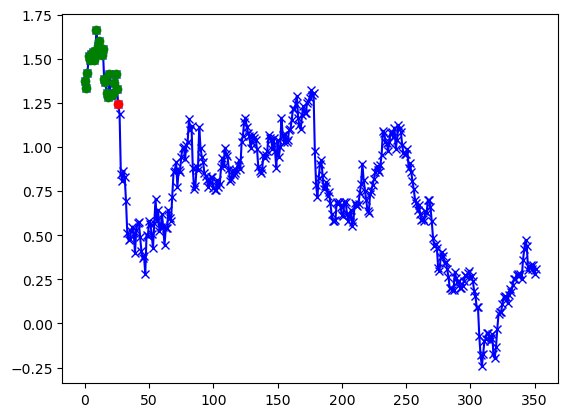

indice range: 1 26 --> 27
[[1.24145761]
 [1.32806716]
 [1.41650261]
 [1.36485015]
 [1.30406703]
 [1.29519709]
 [1.29232749]
 [1.41311115]
 [1.28163206]
 [1.30354517]
 [1.36745863]
 [1.38337181]
 [1.5555472 ]
 [1.5242423 ]
 [1.5299815 ]
 [1.60015602]
 [1.57172111]
 [1.66067841]
 [1.54276435]
 [1.49319891]
 [1.5393729 ]
 [1.52841634]
 [1.49450295]
 [1.51589461]
 [1.42224182]
 [1.33615412]] --> [1.18641369]
shape: (26, 1) --> (1,)


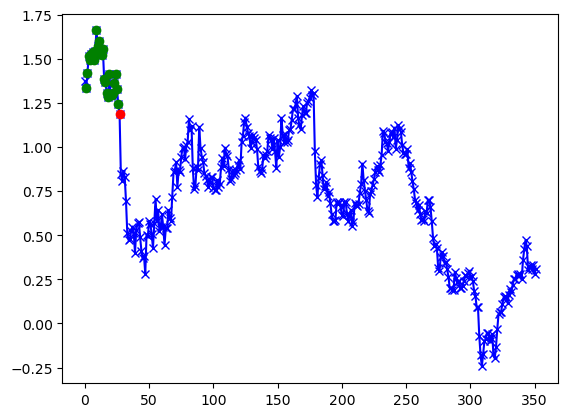

Training: (1382, 26, 1) (1382, 1)
Validation: (326, 26, 1) (326, 1)


In [269]:
Xt_ups, Yt_ups = from_arrays(xt_ups, lookback=25, delay=1, step=1, 
                                   feature_columns=feature_columns_ups, 
                                   target_columns=target_columns_ups, unique=False,verbose=True)

Xv_ups, Yv_ups = from_arrays(xv_ups, lookback=25, delay=1, step=1, 
                                   feature_columns=feature_columns_ups, 
                                   target_columns=target_columns_ups, unique=False,verbose=True)

print('Training:', Xt_ups.shape, Yt_ups.shape)
print('Validation:', Xv_ups.shape, Yv_ups.shape)

In [270]:
def regression_report(yt,ytp,yv,yvp):
    print("---------- Regression report ----------")
    train_mse = np.mean((yt - ytp) ** 2)
    train_mae = np.mean(np.abs(yt - ytp))
    print("TRAINING:")
    print(" MSE:", train_mse)
    print(" MAE:", train_mae)
    # print(" MAPE:",mean_absolute_percentage_error(Yt,Ytp))
    
    # PARITY PLOT
    fig, ax = plt.subplots()
    ax.plot(yt,ytp,'ro')
    ax.plot(yt,yt,'b-')
    ax.set(xlabel='y_data', ylabel='y_predicted',
        title='Training data parity plot (line y=x represents a perfect fit)')
    plt.show()
    
    # PLOT PART OF THE PREDICTED TIME-SERIES
    frac_plot=1.0
    upper=int(frac_plot*yt.shape[0]); 
    # print(int(0.5*yt.shape[0]))
    fig, ax = plt.subplots()
    ax.plot(yt[0:upper],'b-')
    ax.plot(ytp[0:upper],'r-',alpha=0.5)
    ax.plot(ytp[0:upper],'ro',alpha=0.25)
    ax.set(xlabel='index', ylabel='y(t) (blue=actual & red=prediction)', title='Training: Time-series prediction')
    plt.show()

      
    print("VALIDATION:")
    val_mse = np.mean((yv - yvp) ** 2)
    val_mae = np.mean(np.abs(yv - yvp))
    print(" MSE", val_mse)
    print(" MAE", val_mae)
    # print(" MAPE:",mean_absolute_percentage_error(Yt,Ytp))
    
    # PARITY PLOT 
    fig, ax = plt.subplots()
    ax.plot(yv,yvp,'ro')
    ax.plot(yv,yv,'b-')
    ax.set(xlabel='y_data', ylabel='y_predicted',
        title='Validation data parity plot (line y=x represents a perfect fit)')
    plt.show()
    
    # PLOT PART OF THE PREDICTED TIME-SERIES
    upper=int(frac_plot*yv.shape[0])
    fig, ax = plt.subplots()
    ax.plot(yv[0:upper],'b-')
    ax.plot(yvp[0:upper],'r-',alpha=0.5)
    ax.plot(yvp[0:upper],'ro',alpha=0.25)
    ax.set(xlabel='index', ylabel='y(t) (blue=actual & red=prediction)', title='Validation: Time-series prediction')
    plt.show()

    #return train_mse, train_mae, val_mse, val_mae

In [271]:
def history_plot(history):
  FS=18 #fontsize

  history_dict = history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  epochs = range(1, len(loss_values) + 1)
  plt.plot(epochs, loss_values, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

:::


## RNN

::: panel-tabset

### U.S.-Canada Freight Value

Model: "sequential_134"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_55 (SimpleRNN)   (None, 64)                4224      
                                                                 
 dense_134 (Dense)           (None, 1)                 65        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________
None


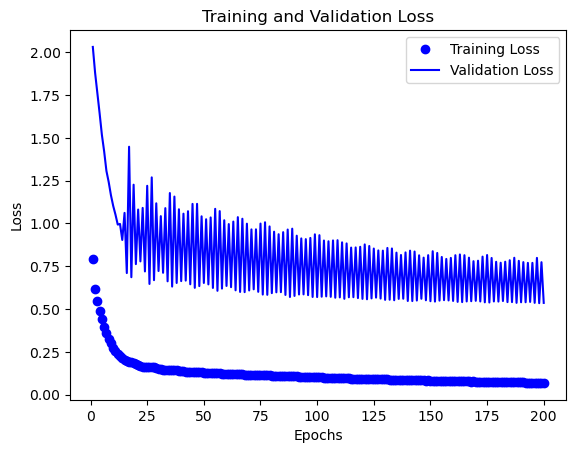

2/2 [==============================] - 0s 3ms/step
---------- Regression report ----------
TRAINING:
 MSE: 0.06076428319397133
 MAE: 0.19017246008247488


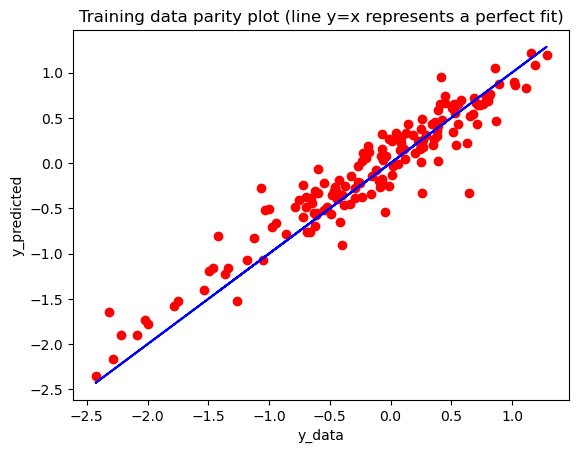

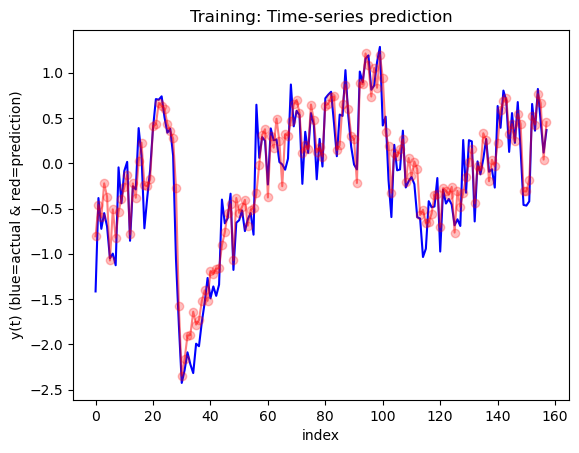

VALIDATION:
 MSE 0.5283236682263021
 MAE 0.47090858458392465


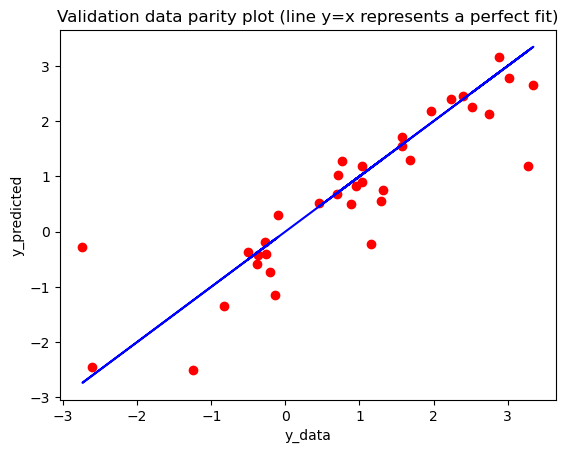

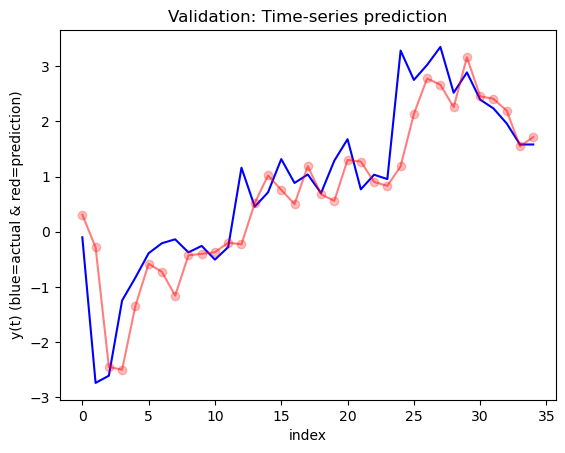

In [292]:
Xt1_canada = Xt_canada.reshape(Xt_canada.shape[0],Xt_canada.shape[1]*Xt_canada.shape[2])

# # HYPERPARAMETERS 
optimizer="rmsprop"
loss_function="MeanSquaredError" 
learning_rate=0.001
numbers_epochs=200 #100
L1 =0 #1e-5
L2=1e-4
input_shape=(Xt_canada.shape[1],Xt_canada.shape[2])

# # batch_size=1                       # stocastic training
# # batch_size=int(len(x_train)/2.)    # mini-batch training
batch_size=len(Xt1_canada)              # batch training

# BUILD MODEL
recurrent_hidden_units=64

# CREATE MODEL
model = keras.Sequential()

# ADD RECURRENT LAYER

# #COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
#model.add(LSTM(
#model.add(GRU(
model.add(SimpleRNN(
units=recurrent_hidden_units,
return_sequences=False,
input_shape=input_shape, 
#recurrent_dropout=0.2,
recurrent_regularizer=regularizers.L2(L2),
activation='relu')
          ) 
    
# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model.add(Dense(units=1, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2), activation='linear'))

# MODEL SUMMARY
print(model.summary()); #print(x_train.shape,y_train.shape)

# # print("initial parameters:", model.get_weights())

# # COMPILING THE MODEL 
opt = keras.optimizers.legacy.RMSprop(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=loss_function)

# TRAINING YOUR MODEL
history_canada = model.fit(Xt_canada,
                    Yt_canada,
                    epochs=numbers_epochs,
                    batch_size=batch_size, verbose=False,
                    validation_data=(Xv_canada, Yv_canada))
# History plot
history_plot(history_canada)

# Predictions 
Ytp_canada=model.predict(Xt_canada)

Yvp_canada=model.predict(Xv_canada) 

# REPORT
regression_report(Yt_canada,Ytp_canada,Yv_canada,Yvp_canada)

### U.S. Air Transportation Employment


Model: "sequential_120"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_51 (SimpleRNN)   (None, 64)                4224      
                                                                 
 dense_120 (Dense)           (None, 1)                 65        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________
None


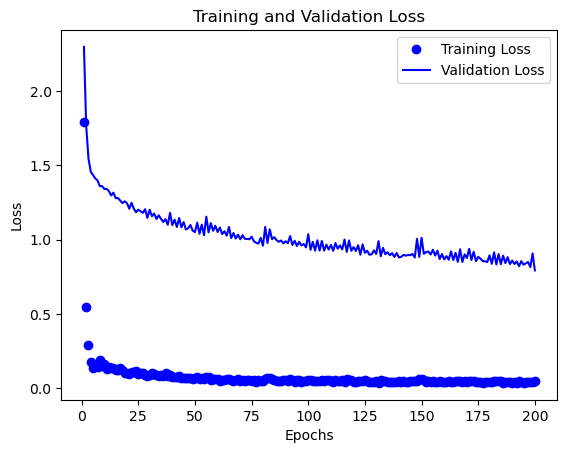

2/2 [==============================] - 0s 3ms/step
---------- Regression report ----------
TRAINING:
 MSE: 0.04963560049846043
 MAE: 0.19326279853125916


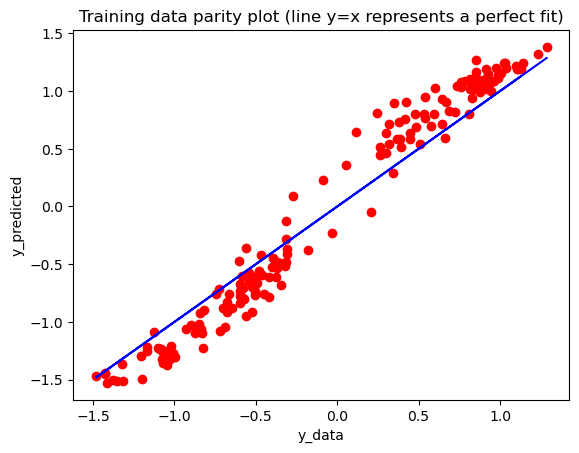

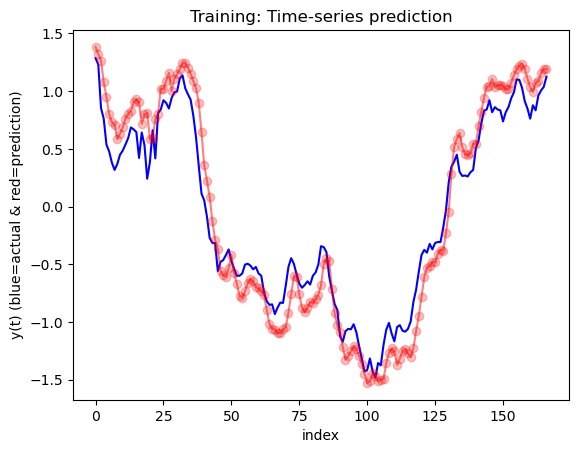

VALIDATION:
 MSE 0.7867605443914162
 MAE 0.5220595282791737


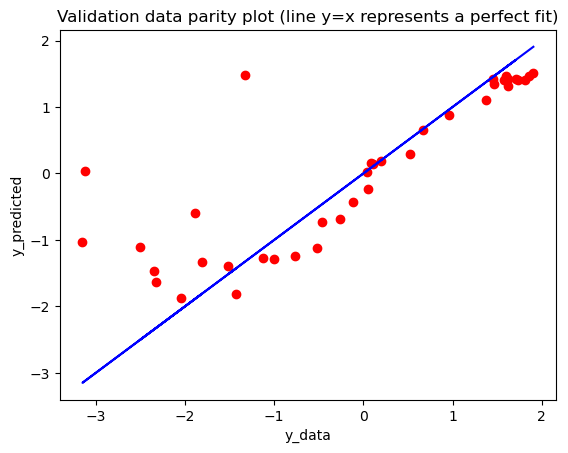

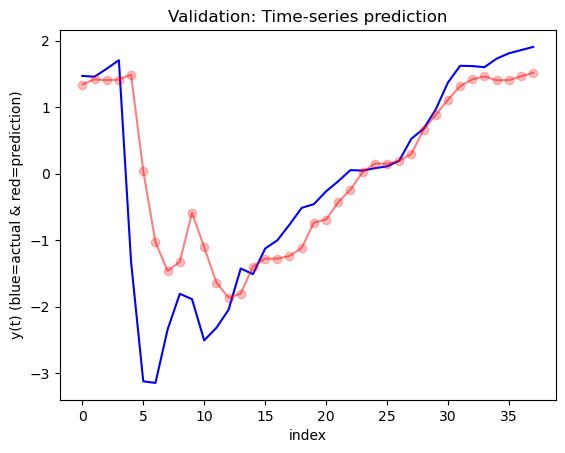

In [273]:
Xt1_employment = Xt_employment.reshape(Xt_employment.shape[0],Xt_employment.shape[1]*Xt_employment.shape[2])

# # HYPERPARAMETERS 
optimizer="rmsprop"
loss_function="MeanSquaredError" 
learning_rate=0.001
numbers_epochs=200 #100
L1 =0 #1e-5
L2=1e-4
input_shape=(Xt_employment.shape[1],Xt_employment.shape[2])

# # batch_size=1                       # stocastic training
# # batch_size=int(len(x_train)/2.)    # mini-batch training
batch_size=len(Xt1_employment)              # batch training

# BUILD MODEL
recurrent_hidden_units=64

# CREATE MODEL
model = keras.Sequential()

# ADD RECURRENT LAYER

# #COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
#model.add(LSTM(
#model.add(GRU(
model.add(SimpleRNN(
units=recurrent_hidden_units,
return_sequences=False,
input_shape=input_shape, 
recurrent_dropout=0.2,
recurrent_regularizer=regularizers.L2(L2),
activation='tanh')
          ) 
     
# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model.add(Dense(units=1, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2), activation='linear'))

# MODEL SUMMARY
print(model.summary()); #print(x_train.shape,y_train.shape)

# # print("initial parameters:", model.get_weights())

# # COMPILING THE MODEL 
opt = keras.optimizers.legacy.RMSprop(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=loss_function)

# TRAINING YOUR MODEL
history_employment = model.fit(Xt_employment,
                    Yt_employment,
                    epochs=numbers_epochs,
                    batch_size=batch_size, verbose=False,
                    validation_data=(Xv_employment, Yv_employment))
# History plot
history_plot(history_employment)

# Predictions 
Ytp_employment=model.predict(Xt_employment)
Yvp_employment=model.predict(Xv_employment) 

# REPORT
regression_report(Yt_employment,Ytp_employment,Yv_employment,Yvp_employment)

### U.S. Freight Transportation Services Index

Model: "sequential_121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_52 (SimpleRNN)   (None, 64)                4224      
                                                                 
 dense_121 (Dense)           (None, 1)                 65        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________
None


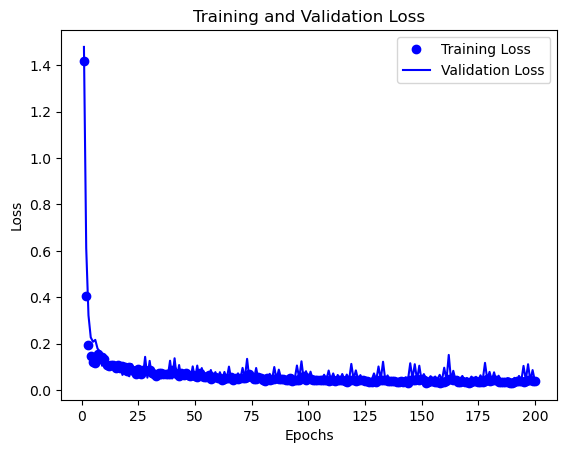

2/2 [==============================] - 0s 4ms/step
---------- Regression report ----------
TRAINING:
 MSE: 0.022784153634049353
 MAE: 0.12228797686836974


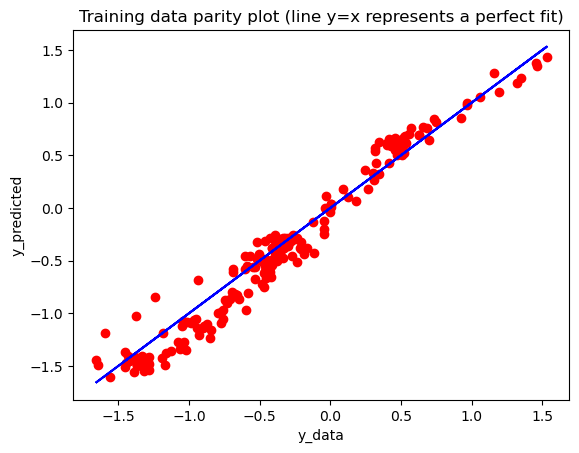

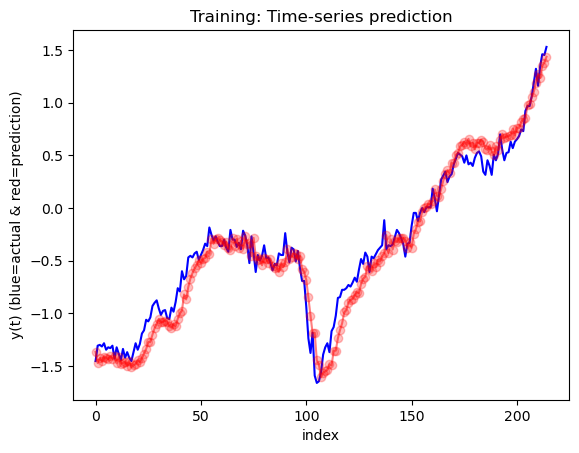

VALIDATION:
 MSE 0.033445470272626225
 MAE 0.12433244080448197


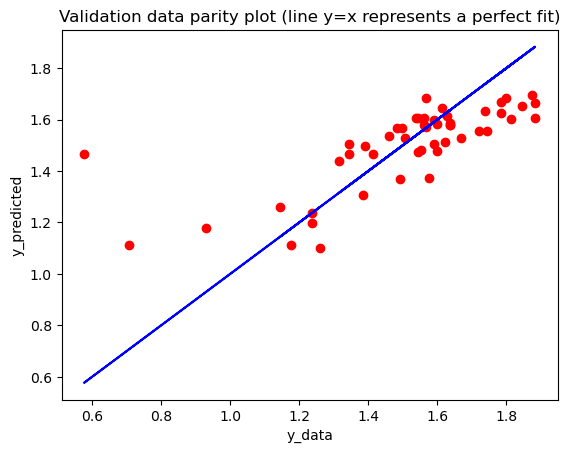

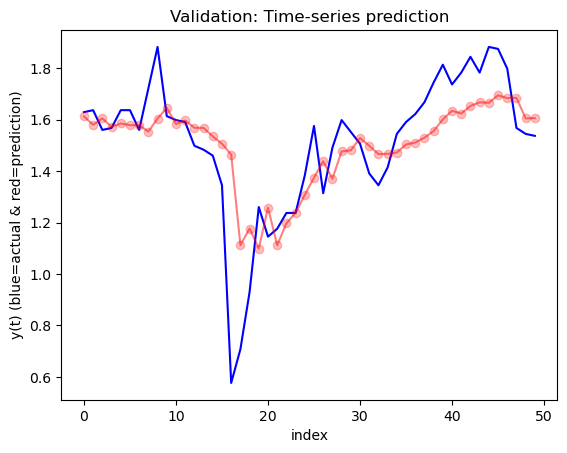

In [274]:
Xt1_tsi = Xt_tsi.reshape(Xt_tsi.shape[0],Xt_tsi.shape[1]*Xt_tsi.shape[2])

# # HYPERPARAMETERS 
optimizer="rmsprop"
loss_function="MeanSquaredError" 
learning_rate=0.001
numbers_epochs=200 #100
L1 =0 #1e-5
L2=1e-4
input_shape=(Xt_tsi.shape[1],Xt_tsi.shape[2])

# # batch_size=1                       # stocastic training
# # batch_size=int(len(x_train)/2.)    # mini-batch training
batch_size=len(Xt1_tsi)              # batch training

# BUILD MODEL
recurrent_hidden_units=64

# CREATE MODEL
model = keras.Sequential()

# ADD RECURRENT LAYER

# #COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
#model.add(LSTM(
#model.add(GRU(
model.add(SimpleRNN(
units=recurrent_hidden_units,
return_sequences=False,
input_shape=input_shape, 
recurrent_dropout=0.2,
recurrent_regularizer=regularizers.L2(L2),
activation='tanh')
          ) 
     
# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model.add(Dense(units=1, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2), activation='linear'))

# MODEL SUMMARY
print(model.summary()); #print(x_train.shape,y_train.shape)

# # print("initial parameters:", model.get_weights())

# # COMPILING THE MODEL 
opt = keras.optimizers.legacy.RMSprop(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=loss_function)

# TRAINING YOUR MODEL
history_tsi = model.fit(Xt_tsi,
                    Yt_tsi,
                    epochs=numbers_epochs,
                    batch_size=batch_size, verbose=False,
                    validation_data=(Xv_tsi, Yv_tsi))
# History plot
history_plot(history_tsi)

# Predictions 
Ytp_tsi=model.predict(Xt_tsi)
Yvp_tsi=model.predict(Xv_tsi) 

# REPORT
regression_report(Yt_tsi,Ytp_tsi,Yv_tsi,Yvp_tsi)

### U.S. Domestic Air Carrier Average Freight Revenue

Model: "sequential_138"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_59 (SimpleRNN)   (None, 32)                1088      
                                                                 
 dense_138 (Dense)           (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________
None


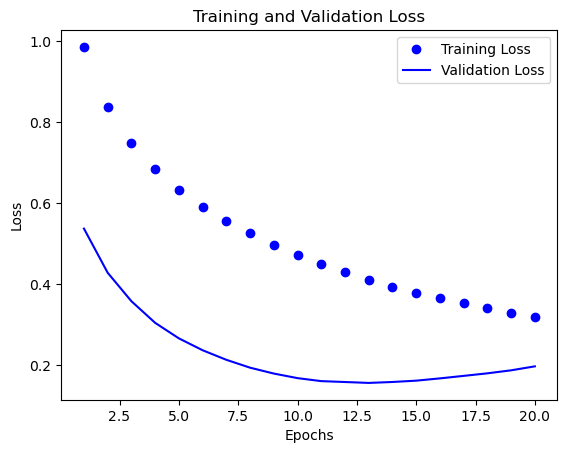

1/1 [==============================] - 0s 23ms/step
---------- Regression report ----------
TRAINING:
 MSE: 0.27522057440104114
 MAE: 0.3597471150559331


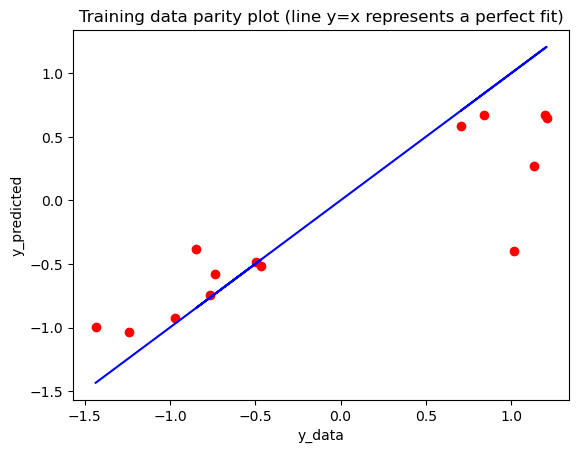

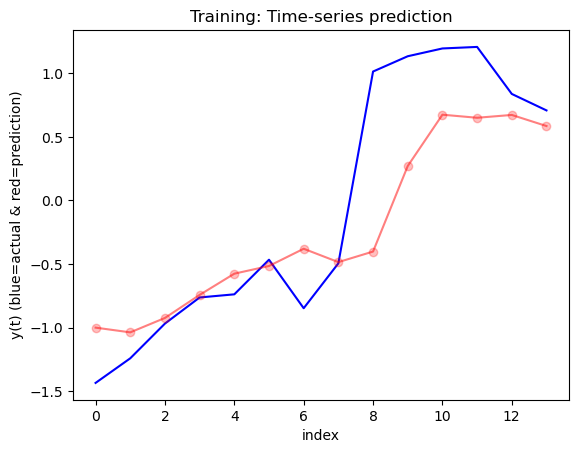

VALIDATION:
 MSE 0.1635487292342209
 MAE 0.3407684377559053


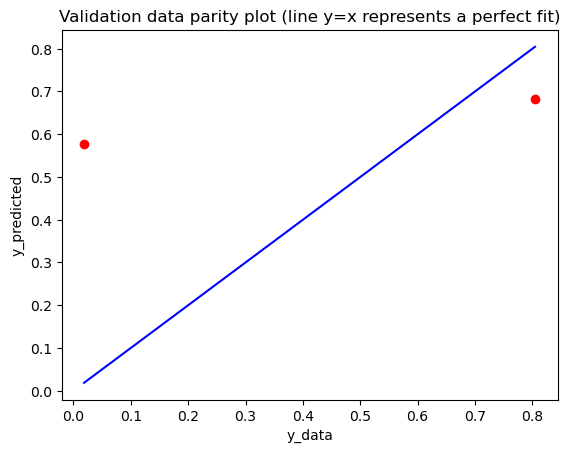

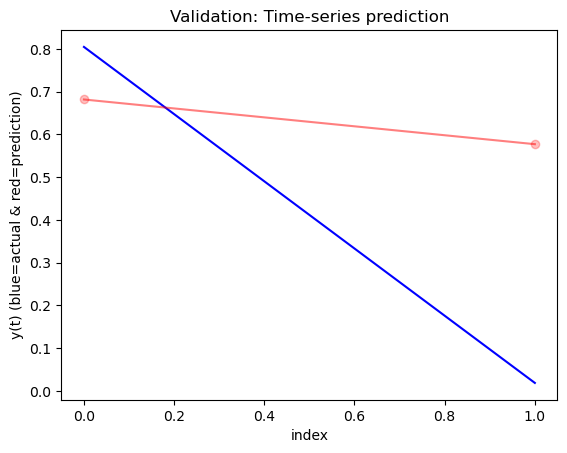

In [296]:
Xt1_air = Xt_air.reshape(Xt_air.shape[0],Xt_air.shape[1]*Xt_air.shape[2])

# # HYPERPARAMETERS 
optimizer="rmsprop"
loss_function="MeanSquaredError" 
learning_rate=0.001
numbers_epochs=20 #100
L1= 0 # 1e-3
L2=1e-3
input_shape=(Xt_air.shape[1],Xt_air.shape[2])

# # batch_size=1                       # stocastic training
# # batch_size=int(len(x_train)/2.)    # mini-batch training
batch_size=len(Xt1_air)              # batch training

# BUILD MODEL
recurrent_hidden_units=32

# CREATE MODEL
model = keras.Sequential()

# ADD RECURRENT LAYER

# #COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
#model.add(LSTM(
#model.add(GRU(
model.add(SimpleRNN(
units=recurrent_hidden_units,
return_sequences=False,
input_shape=input_shape, 
#recurrent_dropout=0.2,
recurrent_regularizer=regularizers.L2(L2),
activation='relu')
          ) 
     
# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model.add(Dense(units=1, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2), activation='linear'))

# MODEL SUMMARY
print(model.summary()); #print(x_train.shape,y_train.shape)

# # print("initial parameters:", model.get_weights())

# # COMPILING THE MODEL 
opt = keras.optimizers.legacy.RMSprop(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=loss_function)

# TRAINING YOUR MODEL
history_air = model.fit(Xt_air,
                    Yt_air,
                    epochs=numbers_epochs,
                    batch_size=batch_size, verbose=False,
                    validation_data=(Xv_air, Yv_air))
# History plot
history_plot(history_air)

# Predictions 
Ytp_air=model.predict(Xt_air)
Yvp_air=model.predict(Xv_air) 

# REPORT
regression_report(Yt_air,Ytp_air,Yv_air,Yvp_air)

### UPS Stock Price

Model: "sequential_123"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_54 (SimpleRNN)   (None, 128)               16640     
                                                                 
 dense_123 (Dense)           (None, 1)                 129       
                                                                 
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________
None


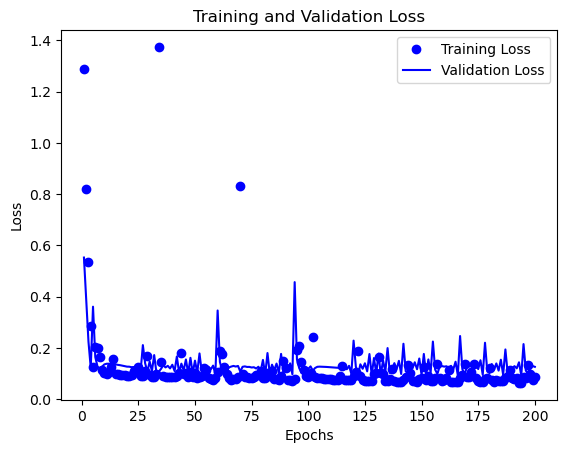

11/11 [==============================] - 0s 2ms/step
---------- Regression report ----------
TRAINING:
 MSE: 0.06063738127136002
 MAE: 0.18525698333701673


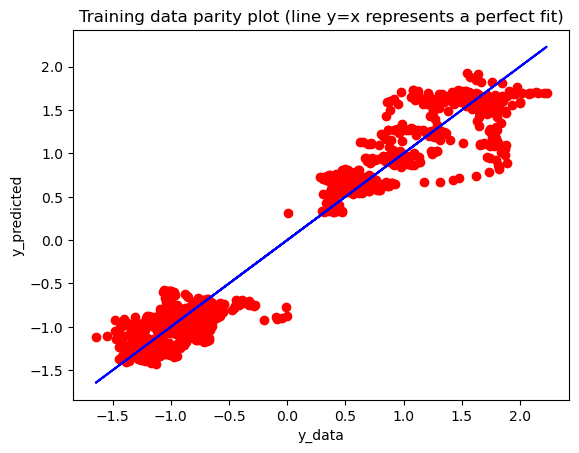

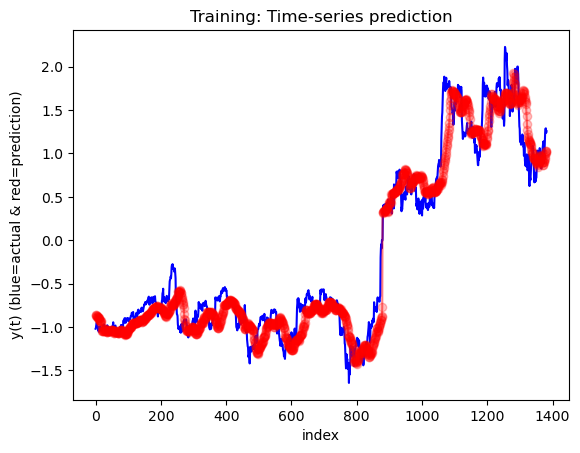

VALIDATION:
 MSE 0.1177780961184615
 MAE 0.2690536328259209


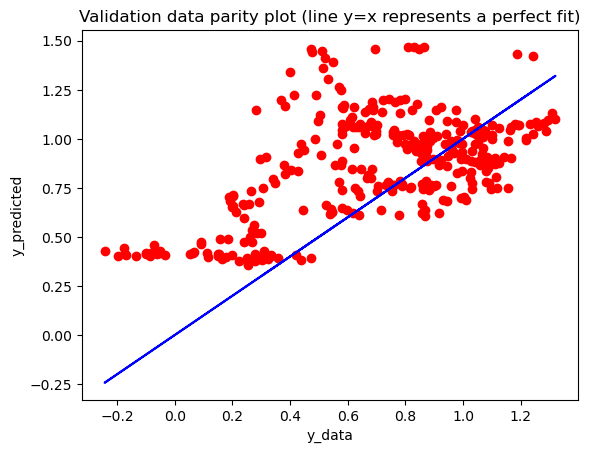

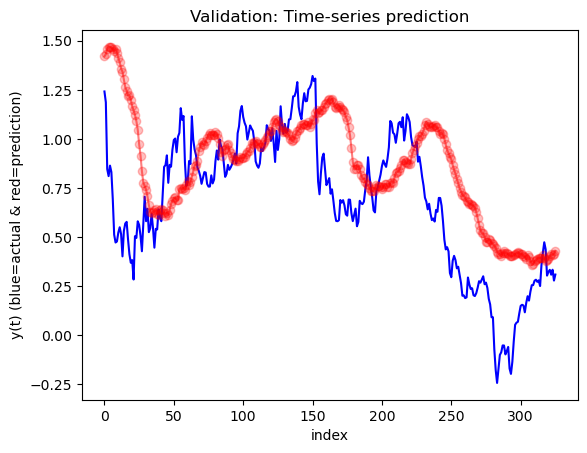

In [276]:
Xt1_ups = Xt_ups.reshape(Xt_ups.shape[0],Xt_ups.shape[1]*Xt_ups.shape[2])

# # HYPERPARAMETERS 
optimizer="rmsprop"
loss_function="MeanSquaredError" 
learning_rate=0.001
numbers_epochs=200 #100
L1 =0 #1e-5
L2=1e-4
input_shape=(Xt_ups.shape[1],Xt_ups.shape[2])

# # batch_size=1                       # stocastic training
# # batch_size=int(len(x_train)/2.)    # mini-batch training
batch_size=len(Xt1_ups)              # batch training

# BUILD MODEL
recurrent_hidden_units=128

# CREATE MODEL
model = keras.Sequential()

# ADD RECURRENT LAYER

# #COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
#model.add(LSTM(
#model.add(GRU(
model.add(SimpleRNN(
units=recurrent_hidden_units,
return_sequences=False,
input_shape=input_shape, 
#recurrent_dropout=0.2,
recurrent_regularizer=regularizers.L2(L2),
activation='relu')
          ) 
     
# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model.add(Dense(units=1, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2), activation='linear'))

# MODEL SUMMARY
print(model.summary()); #print(x_train.shape,y_train.shape)

# # print("initial parameters:", model.get_weights())

# # COMPILING THE MODEL 
opt = keras.optimizers.legacy.RMSprop(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=loss_function)

# TRAINING YOUR MODEL
history_ups = model.fit(Xt_ups,
                    Yt_ups,
                    epochs=numbers_epochs,
                    batch_size=batch_size, verbose=False,
                    validation_data=(Xv_ups, Yv_ups))
# History plot
history_plot(history_ups)

# Predictions 
Ytp_ups=model.predict(Xt_ups)
Yvp_ups=model.predict(Xv_ups) 

# REPORT
regression_report(Yt_ups,Ytp_ups,Yv_ups,Yvp_ups)

:::


## GRU

::: panel-tabset

### U.S.-Canada Freight Value

Model: "sequential_141"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_40 (GRU)                (None, 64)                12864     
                                                                 
 dense_141 (Dense)           (None, 1)                 65        
                                                                 
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________
None


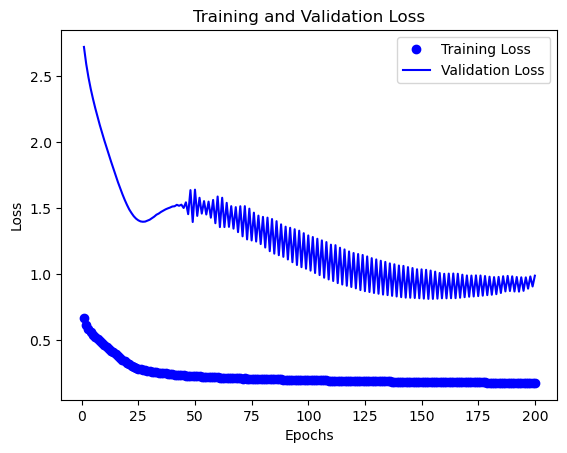

2/2 [==============================] - 0s 2ms/step
---------- Regression report ----------
TRAINING:
 MSE: 0.16747142444617424
 MAE: 0.313622280674025


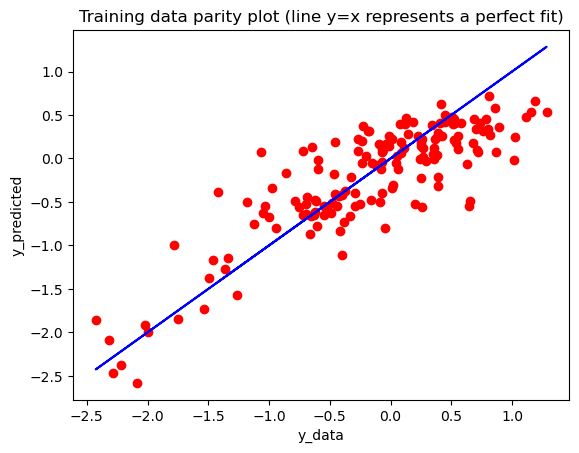

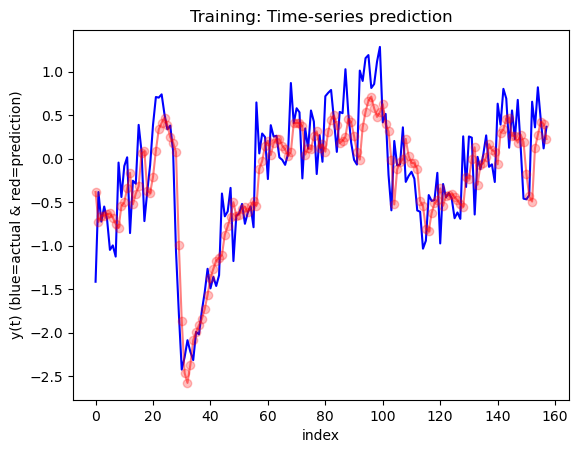

VALIDATION:
 MSE 0.9798029219720011
 MAE 0.6815613419265766


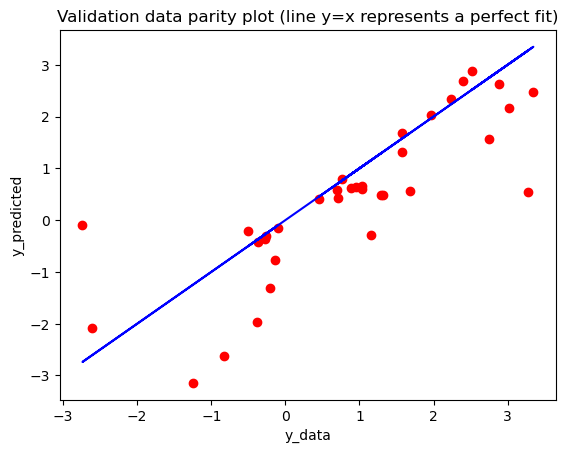

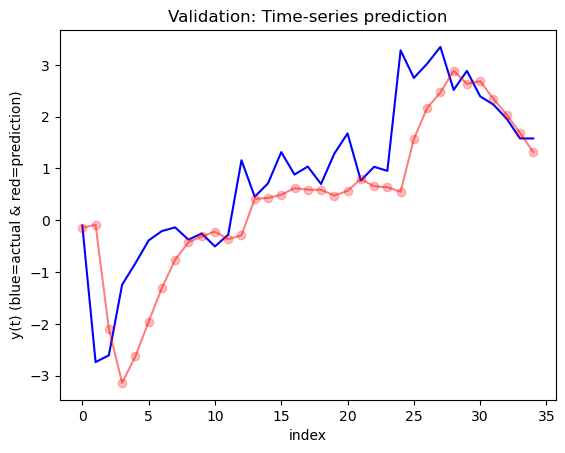

In [299]:
Xt1_canada = Xt_canada.reshape(Xt_canada.shape[0],Xt_canada.shape[1]*Xt_canada.shape[2])

# # HYPERPARAMETERS 
optimizer="rmsprop"
loss_function="MeanSquaredError" 
learning_rate=0.001
numbers_epochs=200 #100
L1 =0 #1e-5
L2=1e-4
input_shape=(Xt_canada.shape[1],Xt_canada.shape[2])

# # batch_size=1                       # stocastic training
# # batch_size=int(len(x_train)/2.)    # mini-batch training
batch_size=len(Xt1_canada)              # batch training

# BUILD MODEL
recurrent_hidden_units=64

# CREATE MODEL
model = keras.Sequential()

# ADD RECURRENT LAYER

# #COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
#model.add(LSTM(
model.add(GRU(
#model.add(SimpleRNN(
units=recurrent_hidden_units,
return_sequences=False,
input_shape=input_shape, 
#recurrent_dropout=0.2,
recurrent_regularizer=regularizers.L2(L2),
activation='relu')
          ) 
    
# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model.add(Dense(units=1, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2), activation='linear'))

# MODEL SUMMARY
print(model.summary()); #print(x_train.shape,y_train.shape)

# # print("initial parameters:", model.get_weights())

# # COMPILING THE MODEL 
opt = keras.optimizers.legacy.RMSprop(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=loss_function)

# TRAINING YOUR MODEL
history_canada = model.fit(Xt_canada,
                    Yt_canada,
                    epochs=numbers_epochs,
                    batch_size=batch_size, verbose=False,
                    validation_data=(Xv_canada, Yv_canada))
# History plot
history_plot(history_canada)

# Predictions 
Ytp_canada=model.predict(Xt_canada)

Yvp_canada=model.predict(Xv_canada) 

# REPORT
regression_report(Yt_canada,Ytp_canada,Yv_canada,Yvp_canada)

### U.S. Air Transportation Employment


Model: "sequential_125"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_34 (GRU)                (None, 64)                12864     
                                                                 
 dense_125 (Dense)           (None, 1)                 65        
                                                                 
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________
None


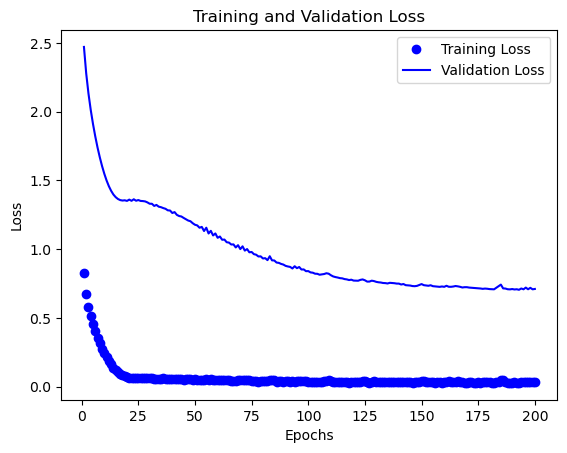

2/2 [==============================] - 0s 3ms/step
---------- Regression report ----------
TRAINING:
 MSE: 0.021659597443868753
 MAE: 0.11735638014549601


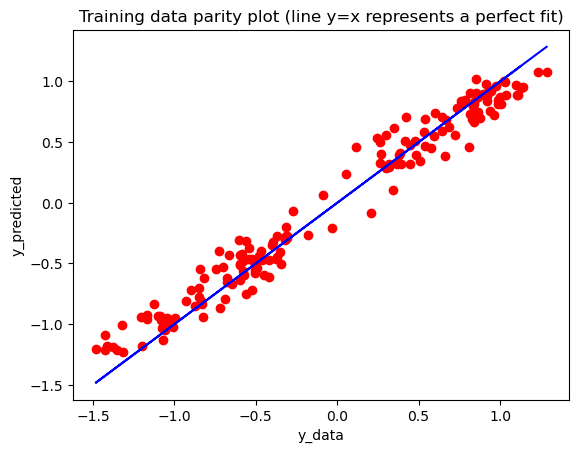

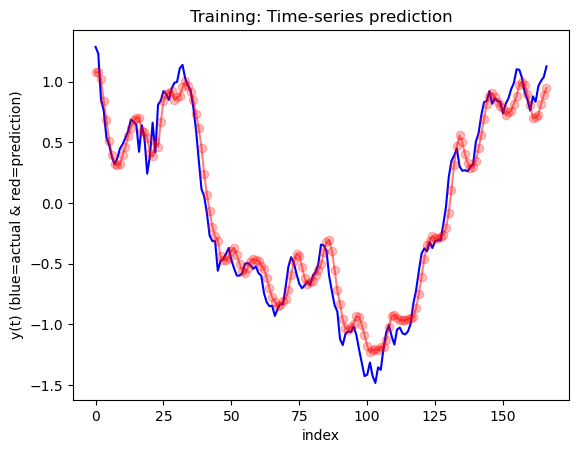

VALIDATION:
 MSE 0.7072622936710634
 MAE 0.500660476322218


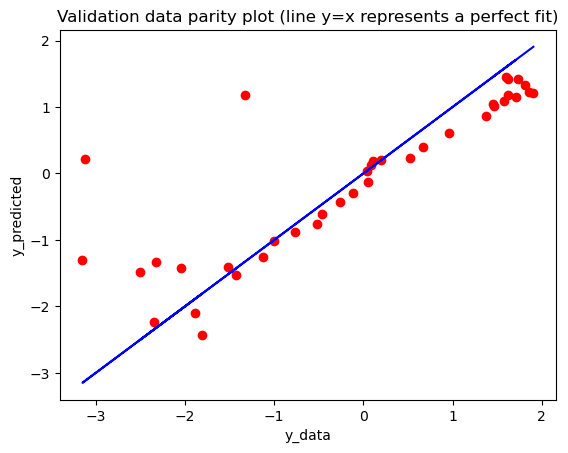

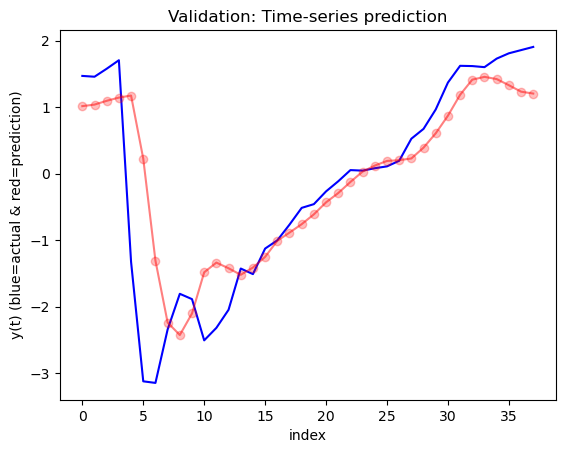

In [278]:
Xt1_employment = Xt_employment.reshape(Xt_employment.shape[0],Xt_employment.shape[1]*Xt_employment.shape[2])

# # HYPERPARAMETERS 
optimizer="rmsprop"
loss_function="MeanSquaredError" 
learning_rate=0.001
numbers_epochs=200 #100
L1 =0 #1e-5
L2=1e-4
input_shape=(Xt_employment.shape[1],Xt_employment.shape[2])

# # batch_size=1                       # stocastic training
# # batch_size=int(len(x_train)/2.)    # mini-batch training
batch_size=len(Xt1_employment)              # batch training

# BUILD MODEL
recurrent_hidden_units=64

# CREATE MODEL
model = keras.Sequential()

# ADD RECURRENT LAYER

# #COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
#model.add(LSTM(
model.add(GRU(
#model.add(SimpleRNN(
units=recurrent_hidden_units,
return_sequences=False,
input_shape=input_shape, 
recurrent_dropout=0.2,
recurrent_regularizer=regularizers.L2(L2),
activation='tanh')
          ) 
     
# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model.add(Dense(units=1, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2), activation='linear'))

# MODEL SUMMARY
print(model.summary()); #print(x_train.shape,y_train.shape)

# # print("initial parameters:", model.get_weights())

# # COMPILING THE MODEL 
opt = keras.optimizers.legacy.RMSprop(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=loss_function)

# TRAINING YOUR MODEL
history_employment = model.fit(Xt_employment,
                    Yt_employment,
                    epochs=numbers_epochs,
                    batch_size=batch_size, verbose=False,
                    validation_data=(Xv_employment, Yv_employment))
# History plot
history_plot(history_employment)

# Predictions 
Ytp_employment=model.predict(Xt_employment)
Yvp_employment=model.predict(Xv_employment) 

# REPORT
regression_report(Yt_employment,Ytp_employment,Yv_employment,Yvp_employment)

### U.S. Freight Transportation Services Index

Model: "sequential_126"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_35 (GRU)                (None, 64)                12864     
                                                                 
 dense_126 (Dense)           (None, 1)                 65        
                                                                 
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________
None


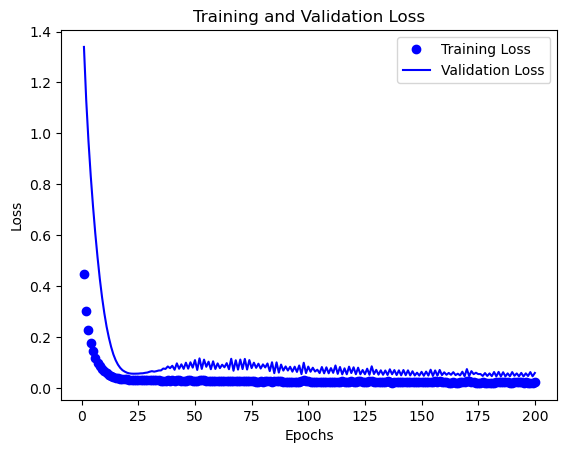

2/2 [==============================] - 0s 3ms/step
---------- Regression report ----------
TRAINING:
 MSE: 0.016227092921605096
 MAE: 0.09903639454789298


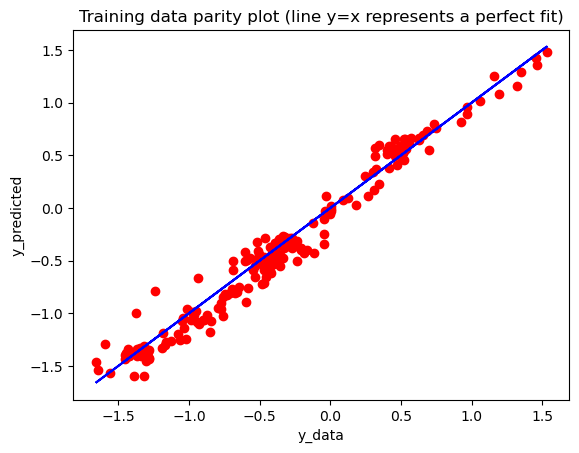

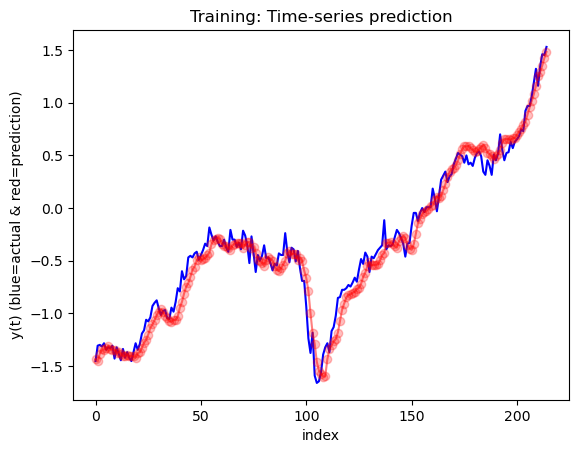

VALIDATION:
 MSE 0.05535462997924422
 MAE 0.1547657842018496


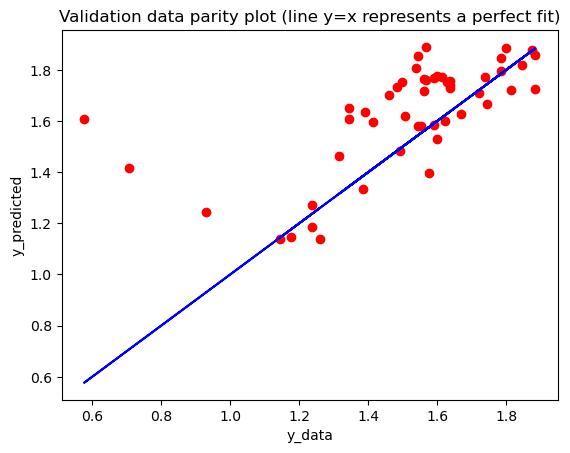

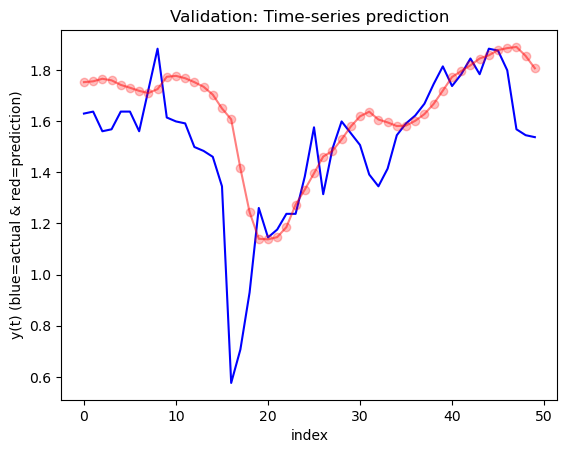

In [279]:
Xt1_tsi = Xt_tsi.reshape(Xt_tsi.shape[0],Xt_tsi.shape[1]*Xt_tsi.shape[2])

# # HYPERPARAMETERS 
optimizer="rmsprop"
loss_function="MeanSquaredError" 
learning_rate=0.001
numbers_epochs=200 #100
L1 =0 # 1e-4
L2=1e-4
input_shape=(Xt_tsi.shape[1],Xt_tsi.shape[2])

# # batch_size=1                       # stocastic training
# # batch_size=int(len(x_train)/2.)    # mini-batch training
batch_size=len(Xt1_tsi)              # batch training

# BUILD MODEL
recurrent_hidden_units=64

# CREATE MODEL
model = keras.Sequential()

# ADD RECURRENT LAYER

# #COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
#model.add(LSTM(
model.add(GRU(
#model.add(SimpleRNN(
units=recurrent_hidden_units,
return_sequences=False,
input_shape=input_shape, 
recurrent_dropout=0.2,
recurrent_regularizer=regularizers.L2(L2),
activation='tanh')
          ) 
     
# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model.add(Dense(units=1, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2), activation='linear'))

# MODEL SUMMARY
print(model.summary()); #print(x_train.shape,y_train.shape)

# # print("initial parameters:", model.get_weights())

# # COMPILING THE MODEL 
opt = keras.optimizers.legacy.RMSprop(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=loss_function)

# TRAINING YOUR MODEL
history_tsi = model.fit(Xt_tsi,
                    Yt_tsi,
                    epochs=numbers_epochs,
                    batch_size=batch_size, verbose=False,
                    validation_data=(Xv_tsi, Yv_tsi))
# History plot
history_plot(history_tsi)

# Predictions 
Ytp_tsi=model.predict(Xt_tsi)
Yvp_tsi=model.predict(Xv_tsi) 

# REPORT
regression_report(Yt_tsi,Ytp_tsi,Yv_tsi,Yvp_tsi)

### U.S. Domestic Air Carrier Average Freight Revenue

Model: "sequential_127"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_36 (GRU)                (None, 32)                3360      
                                                                 
 dense_127 (Dense)           (None, 1)                 33        
                                                                 
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________
None


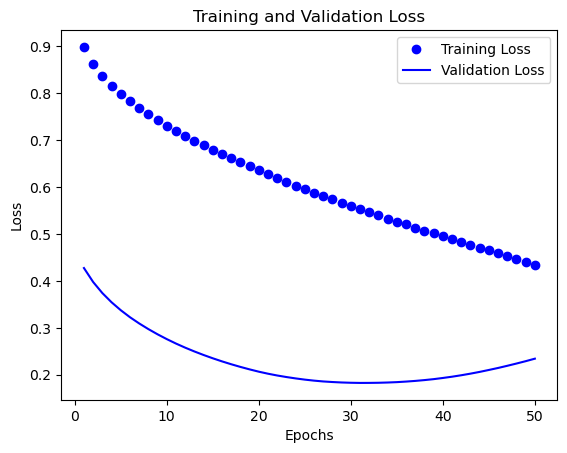

1/1 [==============================] - 0s 25ms/step
---------- Regression report ----------
TRAINING:
 MSE: 0.4063731584754167
 MAE: 0.465517128218001


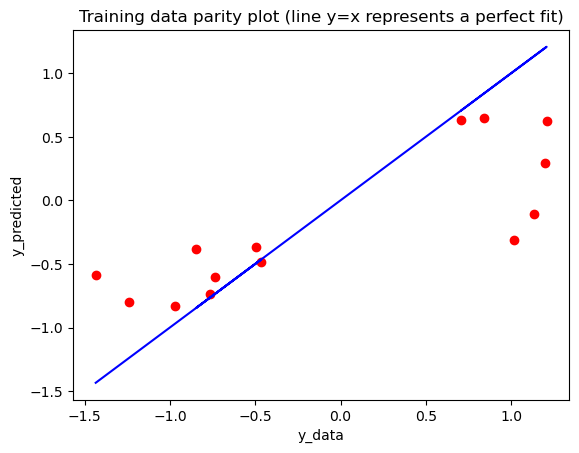

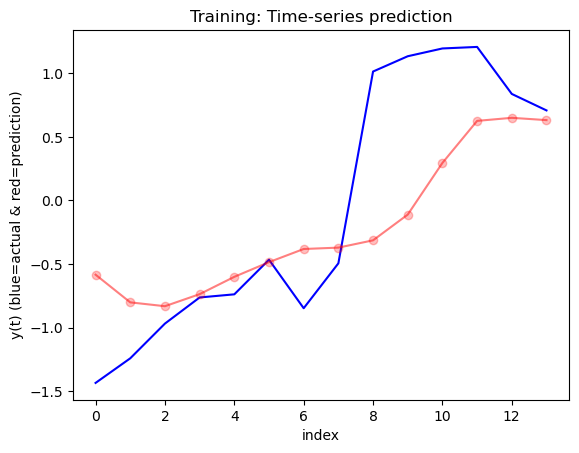

VALIDATION:
 MSE 0.21225410827559443
 MAE 0.4044131151564943


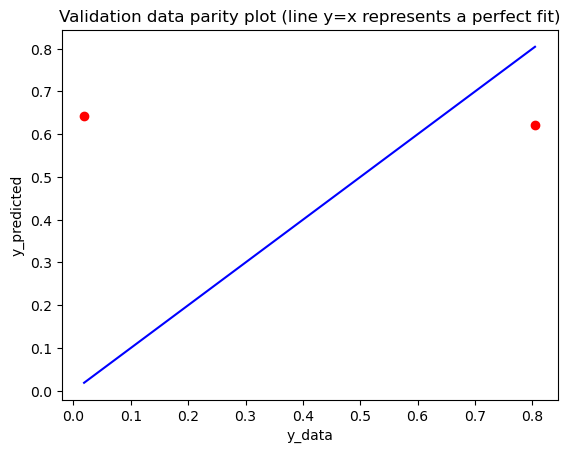

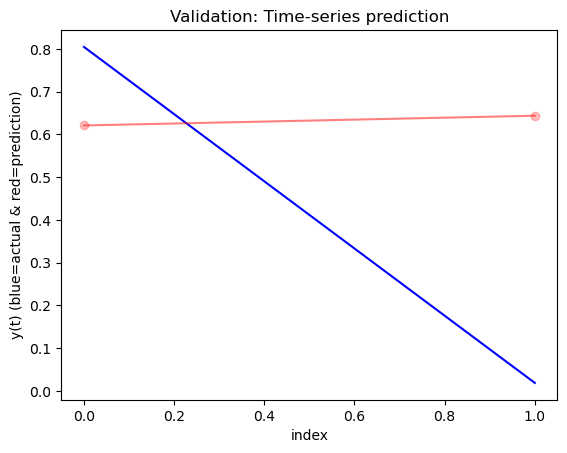

In [280]:
Xt1_air = Xt_air.reshape(Xt_air.shape[0],Xt_air.shape[1]*Xt_air.shape[2])

# # HYPERPARAMETERS 
optimizer="rmsprop"
loss_function="MeanSquaredError" 
learning_rate=0.001
numbers_epochs=50 #100
L1=0 # 1e-3
L2=1e-3
input_shape=(Xt_air.shape[1],Xt_air.shape[2])

# # batch_size=1                       # stocastic training
# # batch_size=int(len(x_train)/2.)    # mini-batch training
batch_size=len(Xt1_air)              # batch training

# BUILD MODEL
recurrent_hidden_units=32

# CREATE MODEL
model = keras.Sequential()

# ADD RECURRENT LAYER

# #COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
#model.add(LSTM(
model.add(GRU(
#model.add(SimpleRNN(
units=recurrent_hidden_units,
return_sequences=False,
input_shape=input_shape, 
#recurrent_dropout=0.2,
recurrent_regularizer=regularizers.L2(L2),
activation='relu')
          ) 
     
# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model.add(Dense(units=1, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2), activation='linear'))

# MODEL SUMMARY
print(model.summary()); #print(x_train.shape,y_train.shape)

# # print("initial parameters:", model.get_weights())

# # COMPILING THE MODEL 
opt = keras.optimizers.legacy.RMSprop(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=loss_function)

# TRAINING YOUR MODEL
history_air = model.fit(Xt_air,
                    Yt_air,
                    epochs=numbers_epochs,
                    batch_size=batch_size, verbose=False,
                    validation_data=(Xv_air, Yv_air))
# History plot
history_plot(history_air)

# Predictions 
Ytp_air=model.predict(Xt_air)
Yvp_air=model.predict(Xv_air) 

# REPORT
regression_report(Yt_air,Ytp_air,Yv_air,Yvp_air)

### UPS Stock Price


Model: "sequential_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_37 (GRU)                (None, 128)               50304     
                                                                 
 dense_128 (Dense)           (None, 1)                 129       
                                                                 
Total params: 50,433
Trainable params: 50,433
Non-trainable params: 0
_________________________________________________________________
None


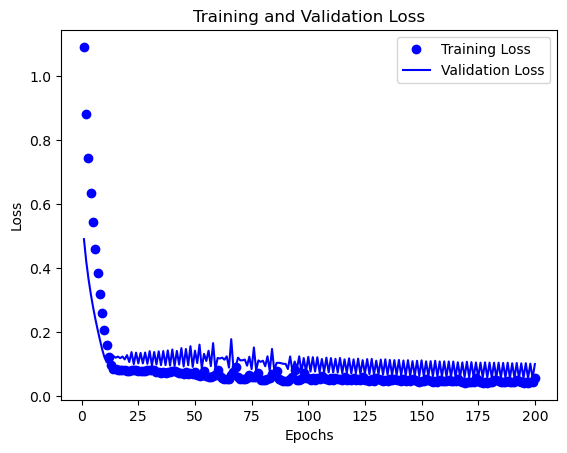

11/11 [==============================] - 0s 5ms/step
---------- Regression report ----------
TRAINING:
 MSE: 0.04272918847380604
 MAE: 0.15938653202471567


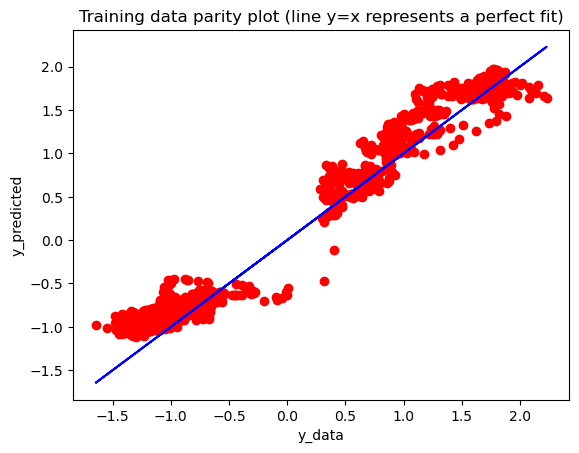

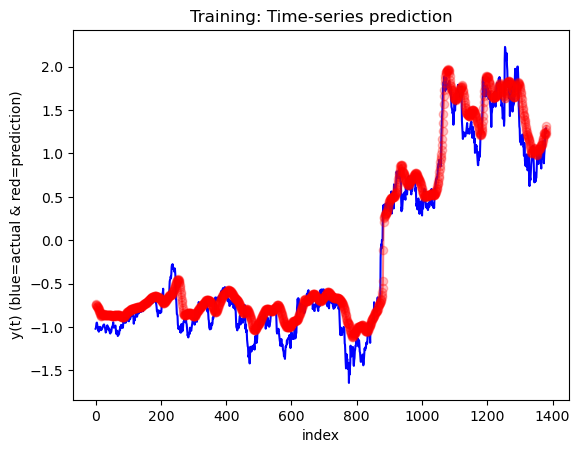

VALIDATION:
 MSE 0.09300636716705062
 MAE 0.24465007861131596


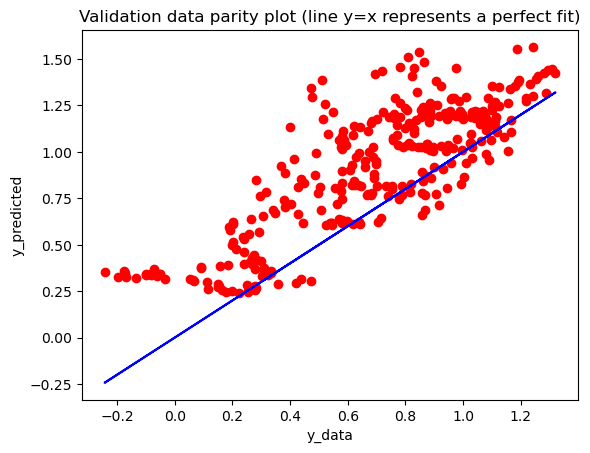

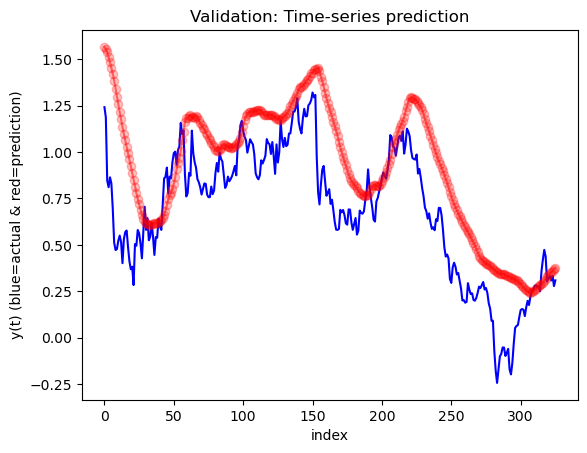

In [281]:
Xt1_ups = Xt_ups.reshape(Xt_ups.shape[0],Xt_ups.shape[1]*Xt_ups.shape[2])

# # HYPERPARAMETERS 
optimizer="rmsprop"
loss_function="MeanSquaredError" 
learning_rate=0.001
numbers_epochs=200 #100
L1 =0 #1e-5
L2=1e-4
input_shape=(Xt_ups.shape[1],Xt_ups.shape[2])

# # batch_size=1                       # stocastic training
# # batch_size=int(len(x_train)/2.)    # mini-batch training
batch_size=len(Xt1_ups)              # batch training

# BUILD MODEL
recurrent_hidden_units=128

# CREATE MODEL
model = keras.Sequential()

# ADD RECURRENT LAYER

# #COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
#model.add(LSTM(
model.add(GRU(
#model.add(SimpleRNN(
units=recurrent_hidden_units,
return_sequences=False,
input_shape=input_shape, 
#recurrent_dropout=0.2,
recurrent_regularizer=regularizers.L2(L2),
activation='relu')
          ) 
     
# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model.add(Dense(units=1, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2), activation='linear'))

# MODEL SUMMARY
print(model.summary()); #print(x_train.shape,y_train.shape)

# # print("initial parameters:", model.get_weights())

# # COMPILING THE MODEL 
opt = keras.optimizers.legacy.RMSprop(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=loss_function)

# TRAINING YOUR MODEL
history_ups = model.fit(Xt_ups,
                    Yt_ups,
                    epochs=numbers_epochs,
                    batch_size=batch_size, verbose=False,
                    validation_data=(Xv_ups, Yv_ups))
# History plot
history_plot(history_ups)

# Predictions 
Ytp_ups=model.predict(Xt_ups)
Yvp_ups=model.predict(Xv_ups) 

# REPORT
regression_report(Yt_ups,Ytp_ups,Yv_ups,Yvp_ups)

:::


## LSTM

::: panel-tabset

### U.S.-Canada Freight Value

Model: "sequential_144"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_43 (LSTM)              (None, 64)                16896     
                                                                 
 dense_144 (Dense)           (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
None


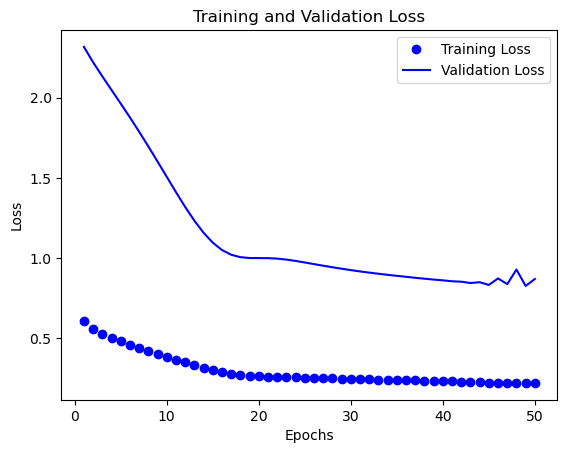

2/2 [==============================] - 0s 2ms/step
---------- Regression report ----------
TRAINING:
 MSE: 0.2096644320357635
 MAE: 0.34340129153435384


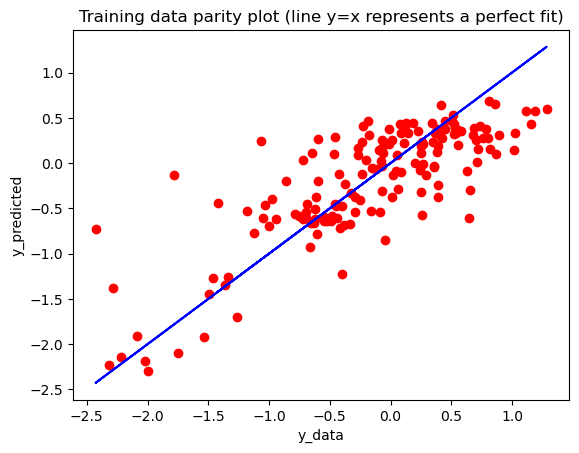

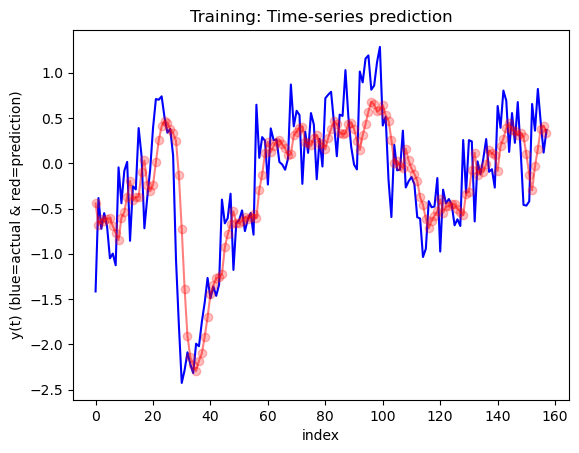

VALIDATION:
 MSE 0.8620759929139857
 MAE 0.639607674604168


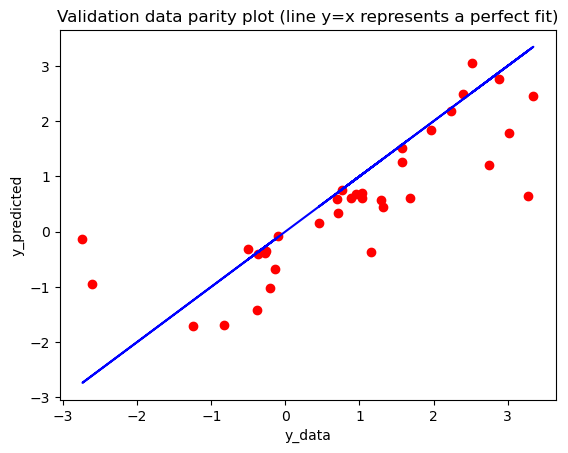

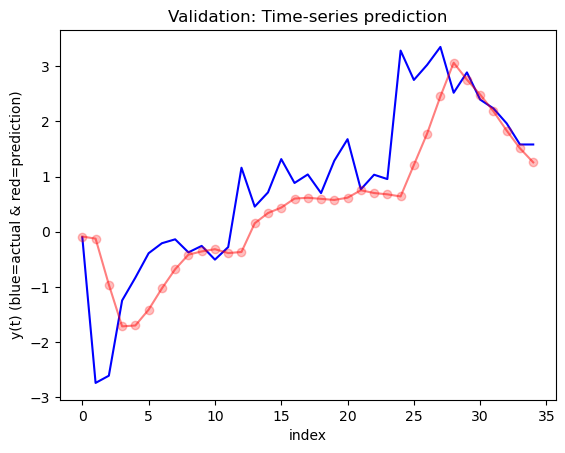

In [302]:
Xt1_canada = Xt_canada.reshape(Xt_canada.shape[0],Xt_canada.shape[1]*Xt_canada.shape[2])

# # HYPERPARAMETERS 
optimizer="adam" #"rmsprop"
loss_function="MeanSquaredError" 
learning_rate=0.001
numbers_epochs=50 #100
L1 =1e-4
L2=1e-4
input_shape=(Xt_canada.shape[1],Xt_canada.shape[2])

# # batch_size=1                       # stocastic training
# # batch_size=int(len(x_train)/2.)    # mini-batch training
batch_size=len(Xt1_canada)              # batch training

# BUILD MODEL
recurrent_hidden_units=64

# CREATE MODEL
model = keras.Sequential()

# ADD RECURRENT LAYER

# #COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
model.add(LSTM(
#model.add(GRU(
#model.add(SimpleRNN(
units=recurrent_hidden_units,
return_sequences=False,
input_shape=input_shape, 
#recurrent_dropout=0.2,
recurrent_regularizer=regularizers.L2(L2),
activation='relu')
          ) 
    
# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model.add(Dense(units=1, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2), activation='linear'))

# MODEL SUMMARY
print(model.summary()); #print(x_train.shape,y_train.shape)

# # print("initial parameters:", model.get_weights())

# # COMPILING THE MODEL 
opt = keras.optimizers.legacy.RMSprop(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=loss_function)

# TRAINING YOUR MODEL
history_canada = model.fit(Xt_canada,
                    Yt_canada,
                    epochs=numbers_epochs,
                    batch_size=batch_size, verbose=False,
                    validation_data=(Xv_canada, Yv_canada))
# History plot
history_plot(history_canada)

# Predictions 
Ytp_canada=model.predict(Xt_canada)

Yvp_canada=model.predict(Xv_canada) 

# REPORT
regression_report(Yt_canada,Ytp_canada,Yv_canada,Yvp_canada)

### U.S. Air Transportation Employment


Model: "sequential_130"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 64)                16896     
                                                                 
 dense_130 (Dense)           (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
None


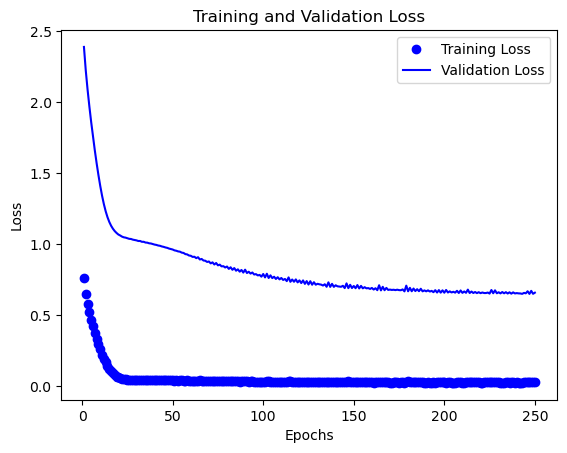

2/2 [==============================] - 0s 3ms/step
---------- Regression report ----------
TRAINING:
 MSE: 0.018522718490930547
 MAE: 0.10661459772446001


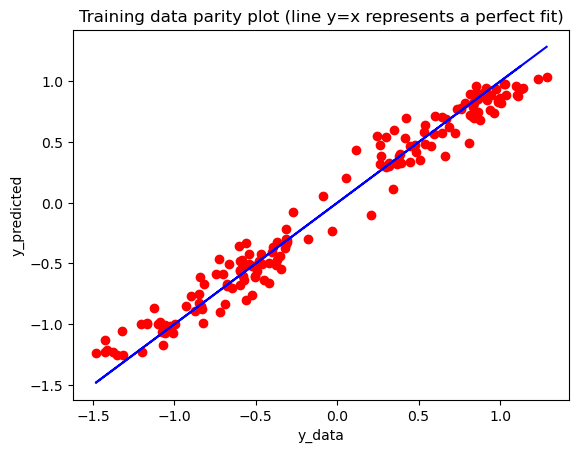

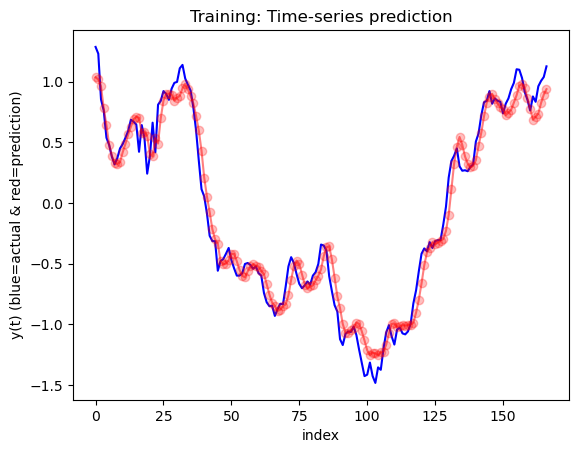

VALIDATION:
 MSE 0.6541035760254018
 MAE 0.5104081585964348


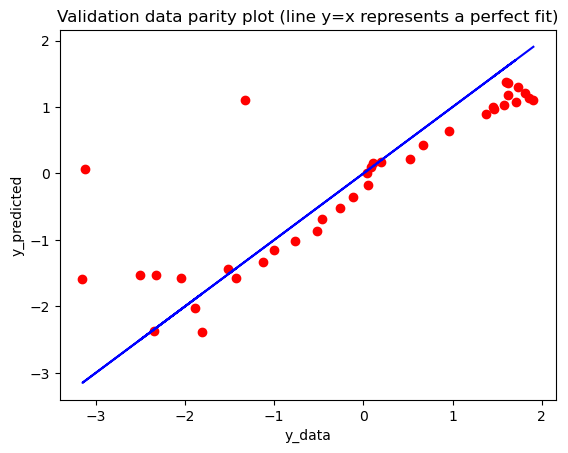

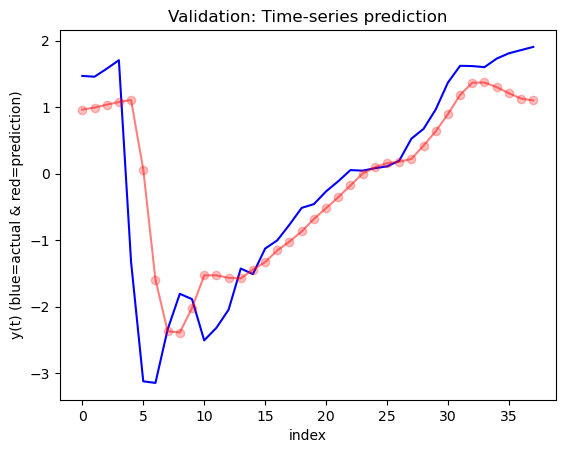

In [283]:
Xt1_employment = Xt_employment.reshape(Xt_employment.shape[0],Xt_employment.shape[1]*Xt_employment.shape[2])

# # HYPERPARAMETERS 
optimizer="rmsprop"
loss_function="MeanSquaredError" 
learning_rate=0.001
numbers_epochs=250 #100
L1 = 1e-4
L2=1e-4
input_shape=(Xt_employment.shape[1],Xt_employment.shape[2])

# # batch_size=1                       # stocastic training
# # batch_size=int(len(x_train)/2.)    # mini-batch training
batch_size=len(Xt1_employment)              # batch training

# BUILD MODEL
recurrent_hidden_units=64

# CREATE MODEL
model = keras.Sequential()

# ADD RECURRENT LAYER

# #COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
model.add(LSTM(
#model.add(GRU(
#model.add(SimpleRNN(
units=recurrent_hidden_units,
return_sequences=False,
input_shape=input_shape, 
recurrent_dropout=0.2,
recurrent_regularizer=regularizers.L2(L2),
activation='tanh')
          ) 
     
# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model.add(Dense(units=1, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2), activation='linear'))

# MODEL SUMMARY
print(model.summary()); #print(x_train.shape,y_train.shape)

# # print("initial parameters:", model.get_weights())

# # COMPILING THE MODEL 
opt = keras.optimizers.legacy.RMSprop(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=loss_function)

# TRAINING YOUR MODEL
history_employment = model.fit(Xt_employment,
                    Yt_employment,
                    epochs=numbers_epochs,
                    batch_size=batch_size, verbose=False,
                    validation_data=(Xv_employment, Yv_employment))
# History plot
history_plot(history_employment)

# Predictions 
Ytp_employment=model.predict(Xt_employment)
Yvp_employment=model.predict(Xv_employment) 

# REPORT
regression_report(Yt_employment,Ytp_employment,Yv_employment,Yvp_employment)

### U.S. Freight Transportation Services Index

Model: "sequential_131"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 64)                16896     
                                                                 
 dense_131 (Dense)           (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
None


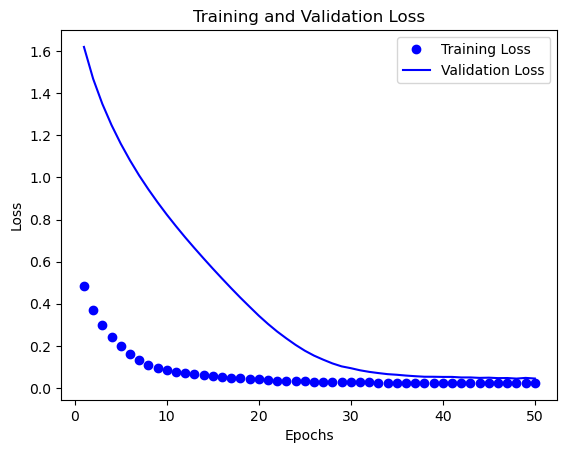

2/2 [==============================] - 0s 3ms/step
---------- Regression report ----------
TRAINING:
 MSE: 0.01977825107913391
 MAE: 0.10792943653958226


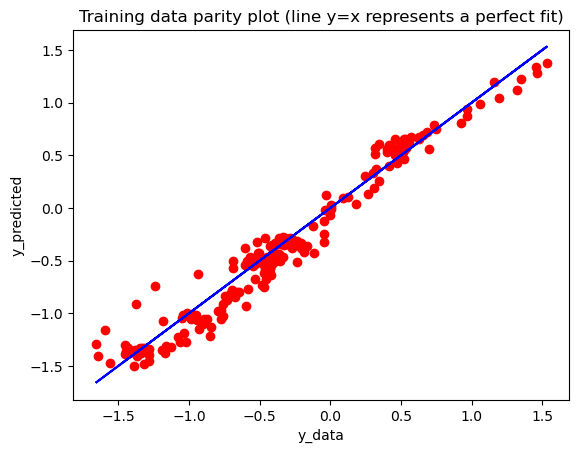

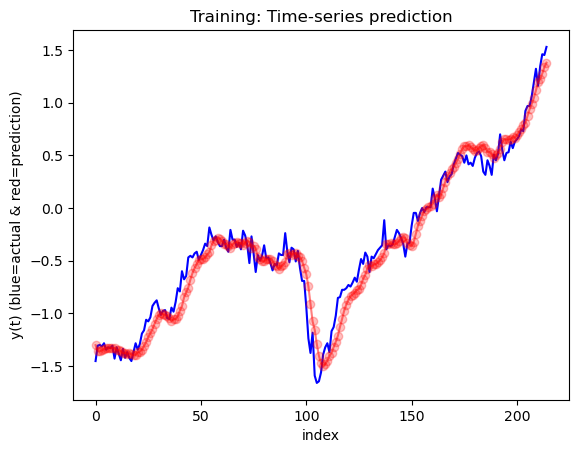

VALIDATION:
 MSE 0.04017445801862534
 MAE 0.13842003755671514


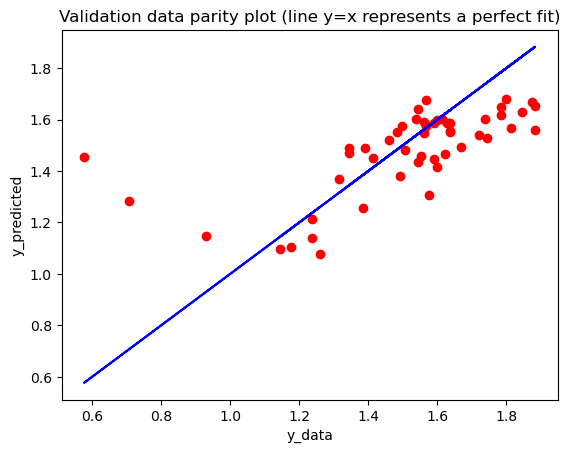

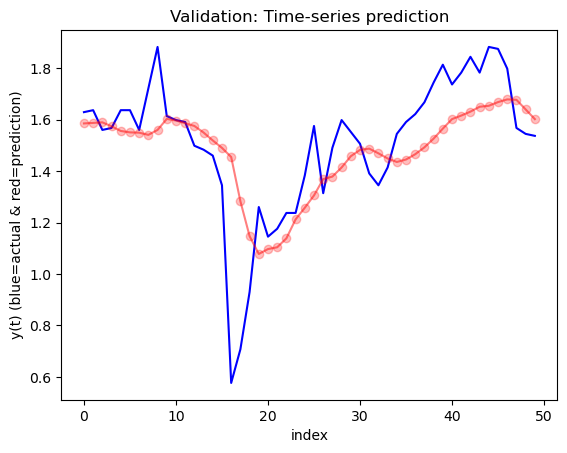

In [284]:
Xt1_tsi = Xt_tsi.reshape(Xt_tsi.shape[0],Xt_tsi.shape[1]*Xt_tsi.shape[2])

# # HYPERPARAMETERS 
optimizer="rmsprop"
loss_function="MeanSquaredError" 
learning_rate=0.001
numbers_epochs=50 #100
L1 =0 #1e-4
L2=1e-4
input_shape=(Xt_tsi.shape[1],Xt_tsi.shape[2])

# # batch_size=1                       # stocastic training
# # batch_size=int(len(x_train)/2.)    # mini-batch training
batch_size=len(Xt1_tsi)              # batch training

# BUILD MODEL
recurrent_hidden_units=64

# CREATE MODEL
model = keras.Sequential()

# ADD RECURRENT LAYER

# #COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
model.add(LSTM(
#model.add(GRU(
#model.add(SimpleRNN(
units=recurrent_hidden_units,
return_sequences=False,
input_shape=input_shape, 
recurrent_dropout=0.2,
recurrent_regularizer=regularizers.L2(L2),
activation='tanh')
          ) 
     
# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model.add(Dense(units=1, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2), activation='linear'))

# MODEL SUMMARY
print(model.summary()); #print(x_train.shape,y_train.shape)

# # print("initial parameters:", model.get_weights())

# # COMPILING THE MODEL 
opt = keras.optimizers.legacy.RMSprop(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=loss_function)

# TRAINING YOUR MODEL
history_tsi = model.fit(Xt_tsi,
                    Yt_tsi,
                    epochs=numbers_epochs,
                    batch_size=batch_size, verbose=False,
                    validation_data=(Xv_tsi, Yv_tsi))
# History plot
history_plot(history_tsi)

# Predictions 
Ytp_tsi=model.predict(Xt_tsi)
Yvp_tsi=model.predict(Xv_tsi) 

# REPORT
regression_report(Yt_tsi,Ytp_tsi,Yv_tsi,Yvp_tsi)

### U.S. Domestic Air Carrier Average Freight Revenue

Model: "sequential_146"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 32)                4352      
                                                                 
 dense_146 (Dense)           (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
None


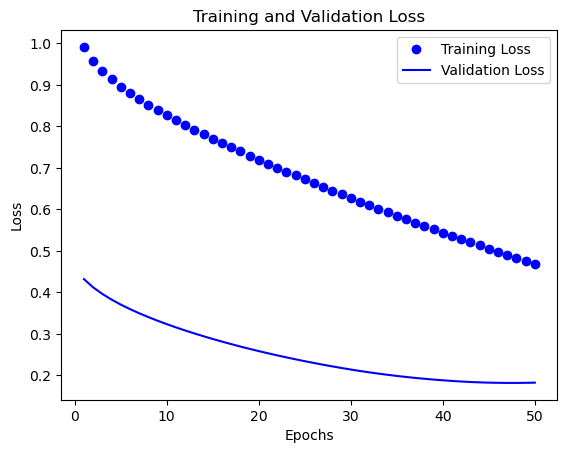

1/1 [==============================] - 0s 16ms/step
---------- Regression report ----------
TRAINING:
 MSE: 0.4301203777536445
 MAE: 0.5311801610940327


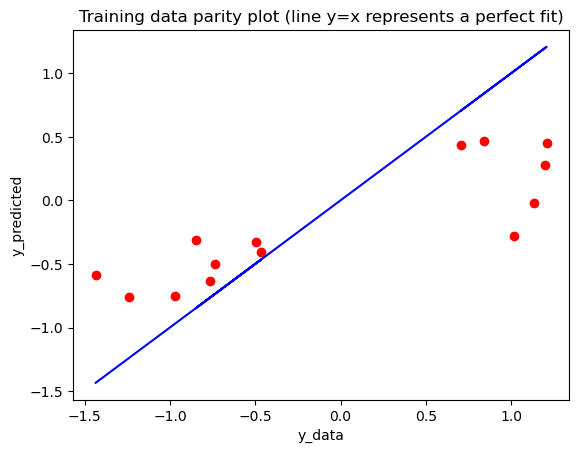

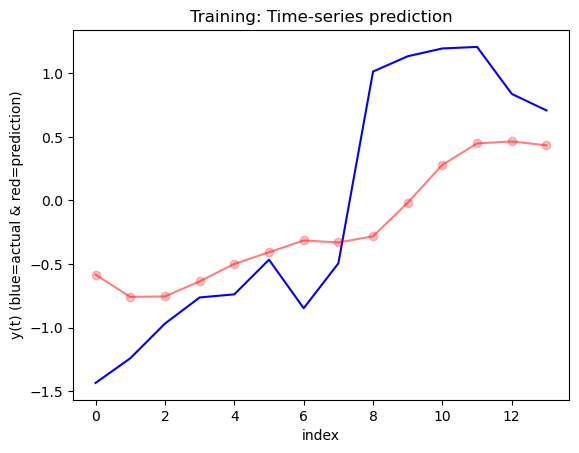

VALIDATION:
 MSE 0.15048526329185513
 MAE 0.3863239250310289


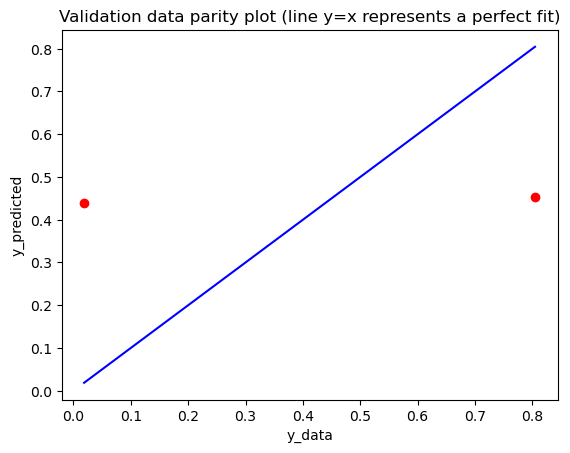

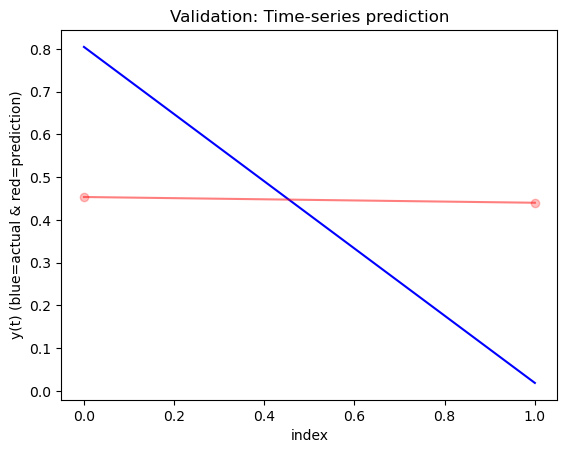

In [304]:
Xt1_air = Xt_air.reshape(Xt_air.shape[0],Xt_air.shape[1]*Xt_air.shape[2])

# # HYPERPARAMETERS 
optimizer="rmsprop"
loss_function="MeanSquaredError" 
learning_rate=0.001
numbers_epochs=50 #100
L1=1e-3
L2=1e-3
input_shape=(Xt_air.shape[1],Xt_air.shape[2])

# # batch_size=1                       # stocastic training
# # batch_size=int(len(x_train)/2.)    # mini-batch training
batch_size=len(Xt1_air)              # batch training

# BUILD MODEL
recurrent_hidden_units=32

# CREATE MODEL
model = keras.Sequential()

# ADD RECURRENT LAYER

# #COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
model.add(LSTM(
#model.add(GRU(
#model.add(SimpleRNN(
units=recurrent_hidden_units,
return_sequences=False,
input_shape=input_shape, 
#recurrent_dropout=0.2,
recurrent_regularizer=regularizers.L2(L2),
activation='relu')
          ) 
     
# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model.add(Dense(units=1, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2), activation='linear'))

# MODEL SUMMARY
print(model.summary()); #print(x_train.shape,y_train.shape)

# # print("initial parameters:", model.get_weights())

# # COMPILING THE MODEL 
opt = keras.optimizers.legacy.RMSprop(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=loss_function)

# TRAINING YOUR MODEL
history_air = model.fit(Xt_air,
                    Yt_air,
                    epochs=numbers_epochs,
                    batch_size=batch_size, verbose=False,
                    validation_data=(Xv_air, Yv_air))
# History plot
history_plot(history_air)

# Predictions 
Ytp_air=model.predict(Xt_air)
Yvp_air=model.predict(Xv_air) 

# REPORT
regression_report(Yt_air,Ytp_air,Yv_air,Yvp_air)

### UPS Stock Price


Model: "sequential_147"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 128)               66560     
                                                                 
 dense_147 (Dense)           (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
None


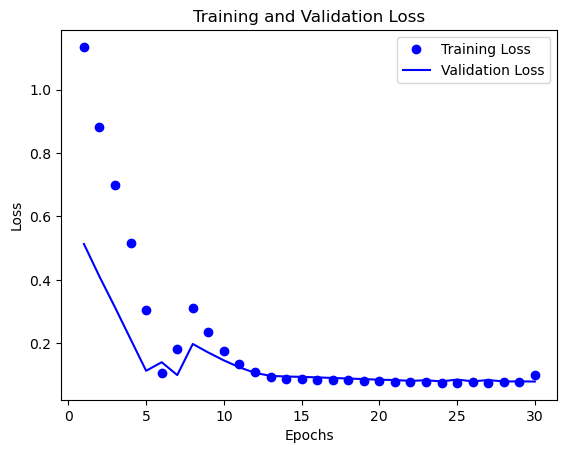

11/11 [==============================] - 0s 7ms/step
---------- Regression report ----------
TRAINING:
 MSE: 0.06872842420933598
 MAE: 0.19469741947055327


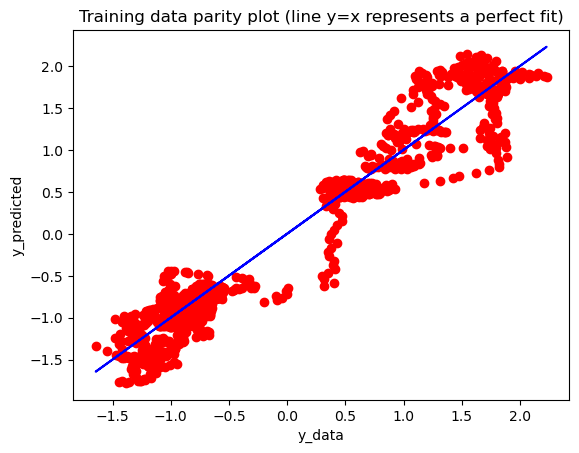

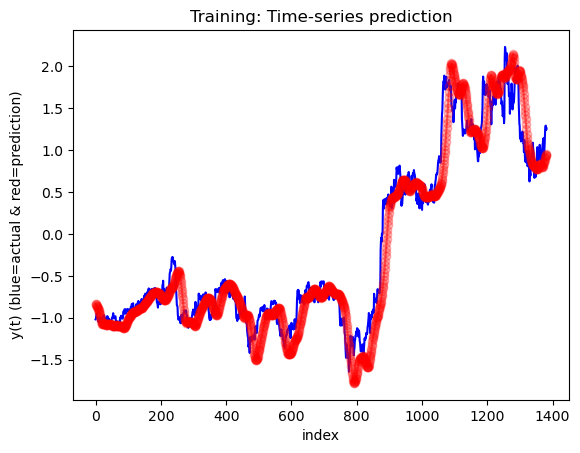

VALIDATION:
 MSE 0.07124300374658443
 MAE 0.2141807240061196


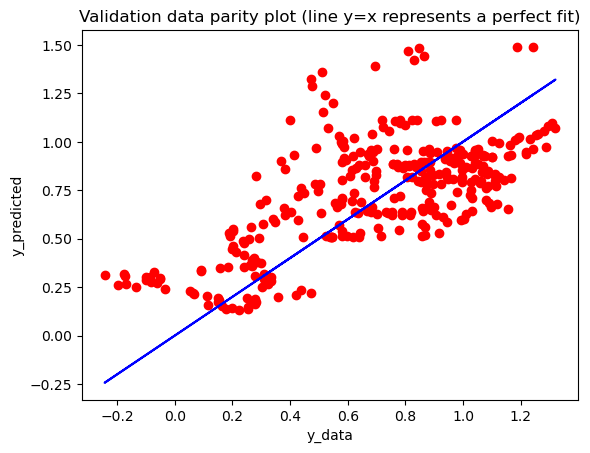

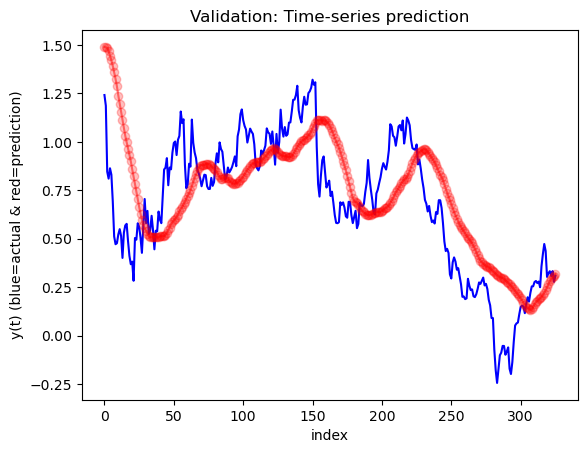

In [305]:
Xt1_ups = Xt_ups.reshape(Xt_ups.shape[0],Xt_ups.shape[1]*Xt_ups.shape[2])

# # HYPERPARAMETERS 
optimizer="rmsprop"
loss_function="MeanSquaredError" 
learning_rate=0.001
numbers_epochs=30 #100
L1 =0 #1e-4
L2=1e-4
input_shape=(Xt_ups.shape[1],Xt_ups.shape[2])

# # batch_size=1                       # stocastic training
# # batch_size=int(len(x_train)/2.)    # mini-batch training
batch_size=len(Xt1_ups)              # batch training

# BUILD MODEL
recurrent_hidden_units=128

# CREATE MODEL
model = keras.Sequential()

# ADD RECURRENT LAYER

# #COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
model.add(LSTM(
#model.add(GRU(
#model.add(SimpleRNN(
units=recurrent_hidden_units,
return_sequences=False,
input_shape=input_shape, 
#recurrent_dropout=0.2,
recurrent_regularizer=regularizers.L2(L2),
activation='relu')
          ) 
     
# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model.add(Dense(units=1, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2), activation='linear'))

# MODEL SUMMARY
print(model.summary()); #print(x_train.shape,y_train.shape)

# # print("initial parameters:", model.get_weights())

# # COMPILING THE MODEL 
opt = keras.optimizers.legacy.RMSprop(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=loss_function)

# TRAINING YOUR MODEL
history_ups = model.fit(Xt_ups,
                    Yt_ups,
                    epochs=numbers_epochs,
                    batch_size=batch_size, verbose=False,
                    validation_data=(Xv_ups, Yv_ups))
# History plot
history_plot(history_ups)

# Predictions 
Ytp_ups=model.predict(Xt_ups)
Yvp_ups=model.predict(Xv_ups) 

# REPORT
regression_report(Yt_ups,Ytp_ups,Yv_ups,Yvp_ups)

:::



## Discussion Questions

### Question 1: How do the results from the 3 different ANN models compare with each other in terms of accuracy and predictive power?

::: panel-tabset

### U.S.-Canada Freight Value

**SIMPLE RNN**

TRAINING:

 MSE: 0.06076428319397133

 MAE: 0.19017246008247488

VALIDATION:

 MSE 0.5283236682263021
 
 MAE 0.47090858458392465

**GRU**

TRAINING:

 MSE: 0.16747142444617424

 MAE: 0.313622280674025

VALIDATION:

 MSE 0.9798029219720011

 MAE 0.6815613419265766

**LSTM**

TRAINING:

 MSE: 0.2096644320357635

 MAE: 0.34340129153435384

VALIDATION:

 MSE 0.8620759929139857
 
 MAE 0.639607674604168

**Conclusion**

The top-performing models in our analysis is the simple RNN models. 


### U.S. Air Transportation Employment


**SIMPLE RNN**

TRAINING:

 MSE: 0.04963560049846043

 MAE: 0.19326279853125916

VALIDATION:

 MSE 0.7867605443914162
 
 MAE 0.5220595282791737

**GRU**

TRAINING:

 MSE: 0.021659597443868753

 MAE: 0.11735638014549601

VALIDATION:

 MSE 0.7072622936710634

 MAE 0.500660476322218

**LSTM**

TRAINING:

 MSE: 0.018522718490930547

 MAE: 0.10661459772446001

VALIDATION:

 MSE 0.6541035760254018
 
 MAE 0.5104081585964348

**Conclusion**

The top-performing models in our analysis is LSTM models. 

### U.S. Freight Transportation Services Index

**SIMPLE RNN**

TRAINING:

 MSE: 0.022784153634049353

 MAE: 0.12228797686836974

VALIDATION:

 MSE 0.033445470272626225
 
 MAE 0.12433244080448197

**GRU**

TRAINING:

 MSE: 0.016227092921605096

 MAE: 0.09903639454789298

VALIDATION:

 MSE 0.05535462997924422

 MAE 0.1547657842018496

**LSTM**

TRAINING:

 MSE: 0.01977825107913391

 MAE: 0.10792943653958226

VALIDATION:

 MSE 0.04017445801862534

 MAE 0.13842003755671514

**Conclusion**

The top-performing models in our analysis is the simple RNN models. 

### U.S. Domestic Air Carrier Average Freight Revenue

**SIMPLE RNN**

TRAINING:

 MSE: 0.27522057440104114

 MAE: 0.3597471150559331

VALIDATION:

 MSE 0.1635487292342209
 
 MAE 0.3407684377559053

**GRU**

TRAINING:

 MSE: 0.4063731584754167

 MAE: 0.465517128218001

VALIDATION:

 MSE 0.21225410827559443

 MAE 0.4044131151564943

**LSTM**

TRAINING:

 MSE: 0.4301203777536445

 MAE: 0.5311801610940327

VALIDATION:

 MSE 0.15048526329185513

 MAE 0.3863239250310289

**Conclusion**

The top-performing models in our analysis is the LSTM models. 


### UPS Stock Price


**SIMPLE RNN**

TRAINING:

 MSE: 0.06063738127136002

 MAE: 0.18525698333701673

VALIDATION:

 MSE 0.1177780961184615

 MAE 0.2690536328259209

**GRU**

TRAINING:

 MSE: 0.04272918847380604

 MAE: 0.15938653202471567

VALIDATION:

 MSE 0.09300636716705062

 MAE 0.24465007861131596

**LSTM**

TRAINING:

 MSE: 0.06872842420933598

 MAE: 0.19469741947055327

VALIDATION:

 MSE 0.07124300374658443
 
 MAE 0.2141807240061196


**Conclusion**

The top-performing models in our analysis is the LSTM models. 

:::

Among these models, the LSTM model showcased superior performance across various metrics, including effectiveness, efficiency in managing complexity and performance trade-offs, accuracy, and predictive power on unseen data. Its ability to capture intricate relationships and patterns within the data is attributed to its more complex architecture.

### Question 2: What effect does including regularization have on the results?

Overfitting occurs when a model performs exceptionally well on training data but poorly on unseen testing or validation data, indicating that it has learned noise rather than true patterns. Regularization addresses this issue by adding a penalty term to the loss function, encouraging the model to prioritize simpler solutions and prevent it from fitting the training data too closely. During parameter tuning, I observed that incorporating regularization techniques notably improved the accuracy of the validation set while effectively controlling overfitting.

### Question 3: How far into the future can the deep learning model accurately predict the future?

Based on our analysis of the provided datasets, the accuracy of predictions hinges on various factors, such as the length and complexity of the data. Our findings suggest that the models generally succeed in capturing the trend and overall fluctuations in unseen data. However, the actual accuracy is heavily influenced by the complexity of the dataset. Specifically, in time series data, when the fluctuations are within certain limits, the models tend to perform better.

### Question 4: How does your deep learning modeling compare to the traditional single-variable time-series ARMA/ARIMA models?

::: panel-tabset

### U.S.-Canada Freight Value

**ARIMA(2,2,3)**

Training set error measures:
                      ME     RMSE      MAE        MPE     MAPE      MASE

Training set -0.02179075 3.105814 2.276102 -0.2721476 4.798624 0.3998011

**SIMPLE RNN**

TRAINING:

MSE: 0.06076428319397133

MAE: 0.19017246008247488

VALIDATION:

MSE 0.5283236682263021

MAE 0.47090858458392465

**Conclusion**

The comparison of RMSE and MAE values between the ARIMA and deep learning models reveals a significant discrepancy, with the deep learning models exhibiting notably lower RMSE and MAE. This suggests that the deep learning models may be better equipped to handle the data and produce more accurate predictions compared to the ARIMA models.


### U.S. Air Transportation Employment

**ARIMA(2,2,3)**

Training set error measures:
                   ME     RMSE      MAE        MPE      MAPE      MASE

Training set 263.3125 6241.208 2809.261 0.05105339 0.6005098 0.1456793

**LSTM**

TRAINING:

MSE: 0.018522718490930547

MAE: 0.10661459772446001

VALIDATION:

MSE 0.6541035760254018

MAE 0.5104081585964348

**Conclusion**

The comparison of RMSE and MAE values between the ARIMA and deep learning models reveals a significant discrepancy, with the deep learning models exhibiting notably lower RMSE and MAE. This suggests that the deep learning models may be better equipped to handle the data and produce more accurate predictions compared to the ARIMA models.

### U.S. Freight Transportation Services Index

**ARIMA(0,1,3)**

Training set error measures:
                       ME     RMSE      MAE         MPE      MAPE      MASE

Training set 0.0007283871 1.475506 1.068367 -0.01205377 0.9267941 0.2634875

**SIMPLE RNN**

TRAINING:

MSE: 0.022784153634049353

MAE: 0.12228797686836974

VALIDATION:

MSE 0.033445470272626225

MAE 0.12433244080448197

**Conclusion**

The comparison of RMSE and MAE values between the ARIMA and deep learning models reveals a significant discrepancy, with the deep learning models exhibiting notably lower RMSE and MAE. This suggests that the deep learning models may be better equipped to handle the data and produce more accurate predictions compared to the ARIMA models.

### U.S. Domestic Air Carrier Average Freight Revenue

**ARIMA(0,1,1)**

Training set error measures:
                    ME     RMSE      MAE       MPE     MAPE      MASE      ACF1

Training set 0.2965719 11.79289 8.992931 0.1888945 9.662775 0.8915005 -0.264417

**LSTM**

TRAINING:

MSE: 0.4301203777536445

MAE: 0.5311801610940327

VALIDATION:

MSE 0.15048526329185513

MAE 0.3863239250310289

**Conclusion**

The comparison of RMSE and MAE values between the ARIMA and deep learning models reveals a significant discrepancy, with the deep learning models exhibiting notably lower RMSE and MAE. This suggests that the deep learning models may be better equipped to handle the data and produce more accurate predictions compared to the ARIMA models.

### UPS Stock Price

**ARIMA(0,1,0)**

Training set error measures:
                       ME     RMSE     MAE         MPE     MAPE       MASE
                       
Training set 5.173998e-05 2.336453 1.51377 -0.01543305 1.161838 0.04821096

**LSTM**

TRAINING:

MSE: 0.06872842420933598

MAE: 0.19469741947055327

VALIDATION:

MSE 0.07124300374658443

MAE 0.2141807240061196

**Conclusion**

The comparison of RMSE and MAE values between the ARIMA and deep learning models reveals a significant discrepancy, with the deep learning models exhibiting notably lower RMSE and MAE. This suggests that the deep learning models may be better equipped to handle the data and produce more accurate predictions compared to the ARIMA models.

:::

# Deep Learning vs. Traditional Time Series

Overall, this analysis underscores the effectiveness of deep learning models in time series forecasting. While it's challenging to directly compare deep learning and traditional time series models due to differences in training/validation splits, the RMSE values reveal a trend favoring deep learning. The higher RMSE values observed with traditional models, particularly for the U.S. Air Transportation Employment data, suggest limitations in capturing data variance. In contrast, deep learning models consistently exhibit lower RMSE values, often below 1.

Comparing the training/validation plots of deep learning models to the forecasting plots of traditional models, we observe that deep learning models align more closely with the real data trend. This disparity underscores the struggle of traditional ARIMA models in harnessing data variance, while deep learning models effectively memorize it. In this analysis, the hierarchy of deep learning model performance was evident, with LSTM outperforming. This hierarchy is intuitive, given that RNN is the simplest form of sequential neural network, while GRU and LSTM represent advancements.

Traditional time series models typically require data to be stationary, often necessitating differencing to achieve forecasting accuracy. However, even with differencing, satisfactory results may not be attainable. Deep learning models, on the other hand, serve as universal curve-fitters, capable of accommodating various data variances. This adaptability renders deep learning models more suitable for forecasting datasets characterized by fluctuations and seasonal patterns.
